In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from pandas.plotting import register_matplotlib_converters
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score

%matplotlib inline
%config InlineBackend.figure_format = "retina"


register_matplotlib_converters()
sns.set(style = "whitegrid", palette = "muted", font_scale = 1.5)

rcParams["figure.figsize"] = 22, 10

In [3]:
from pandas import read_csv, unique

import numpy as np
import pandas as pd

from scipy.interpolate import interp1d
from scipy.stats import mode

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

from tensorflow import stack
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential
from tensorflow.keras.layers import Bidirectional, LSTM, Dropout, Dense
from keras.layers import Dense, GlobalAveragePooling1D, BatchNormalization, MaxPool1D, Reshape, Activation
from tensorflow.keras.layers import Conv1D, Flatten, Reshape, MaxPooling1D
from keras.callbacks import ModelCheckpoint, EarlyStopping
import matplotlib.pyplot as plt

In [4]:
names = ["user_id", "activity", "timestamp", "x_axis", "y_axis", "z_axis", "NaN"]
data = pd.read_csv("/content/drive/MyDrive/WISDM_ar_v1.1/WISDM_ar_v1.1_raw.txt", header=None, names=names, comment=";")

def convert_to_float(x):
    try:
        return np.float(x)
    except:
        return np.nan

df = data.drop('NaN', axis=1)
df["z_axis"].replace(regex = True, inplace = True, to_replace = r';', value = r'')
    # ... and then this column must be transformed to float explicitly
df["z_axis"] = df["z_axis"].apply(convert_to_float)
    # This is very important otherwise the model will not fit and loss will show up as NAN
df.dropna(axis=0, how='any', inplace=True)
df.head()
print(df.shape)

<ipython-input-4-56736d26e660>:6: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  return np.float(x)


(1098204, 6)


In [5]:
mapping = {'Walking': 0, 'Jogging': 1, 'Upstairs': 2, 'Downstairs': 3, 'Sitting': 4, 'Standing': 5}

# 레이블 인코딩
df['ActivityEncoded'] = df['activity'].map(mapping)
df

user_id activity        timestamp    x_axis     y_axis    z_axis  \
0             33  Jogging   49105962326000 -0.694638  12.680544  0.503953   
1             33  Jogging   49106062271000  5.012288  11.264028  0.953424   
2             33  Jogging   49106112167000  4.903325  10.882658 -0.081722   
3             33  Jogging   49106222305000 -0.612916  18.496431  3.023717   
4             33  Jogging   49106332290000 -1.184970  12.108489  7.205164   
...          ...      ...              ...       ...        ...       ...   
1098200       19  Sitting  131623331483000  9.000000  -1.570000  1.690000   
1098201       19  Sitting  131623371431000  9.040000  -1.460000  1.730000   
1098202       19  Sitting  131623411592000  9.080000  -1.380000  1.690000   
1098203       19  Sitting  131623491487000  9.000000  -1.460000  1.730000   
1098204       19  Sitting  131623531465000  8.880000  -1.330000  1.610000   

         ActivityEncoded  
0                      1  
1                      1  
2                      1  
3                      1  
4                      1  
...                  ...  
1098200                4  
1098201                4  
1098202                4  
1098203                4  
1098204                4  

[1098204 rows x 7 columns]

<Axes: xlabel='activity', ylabel='count'>

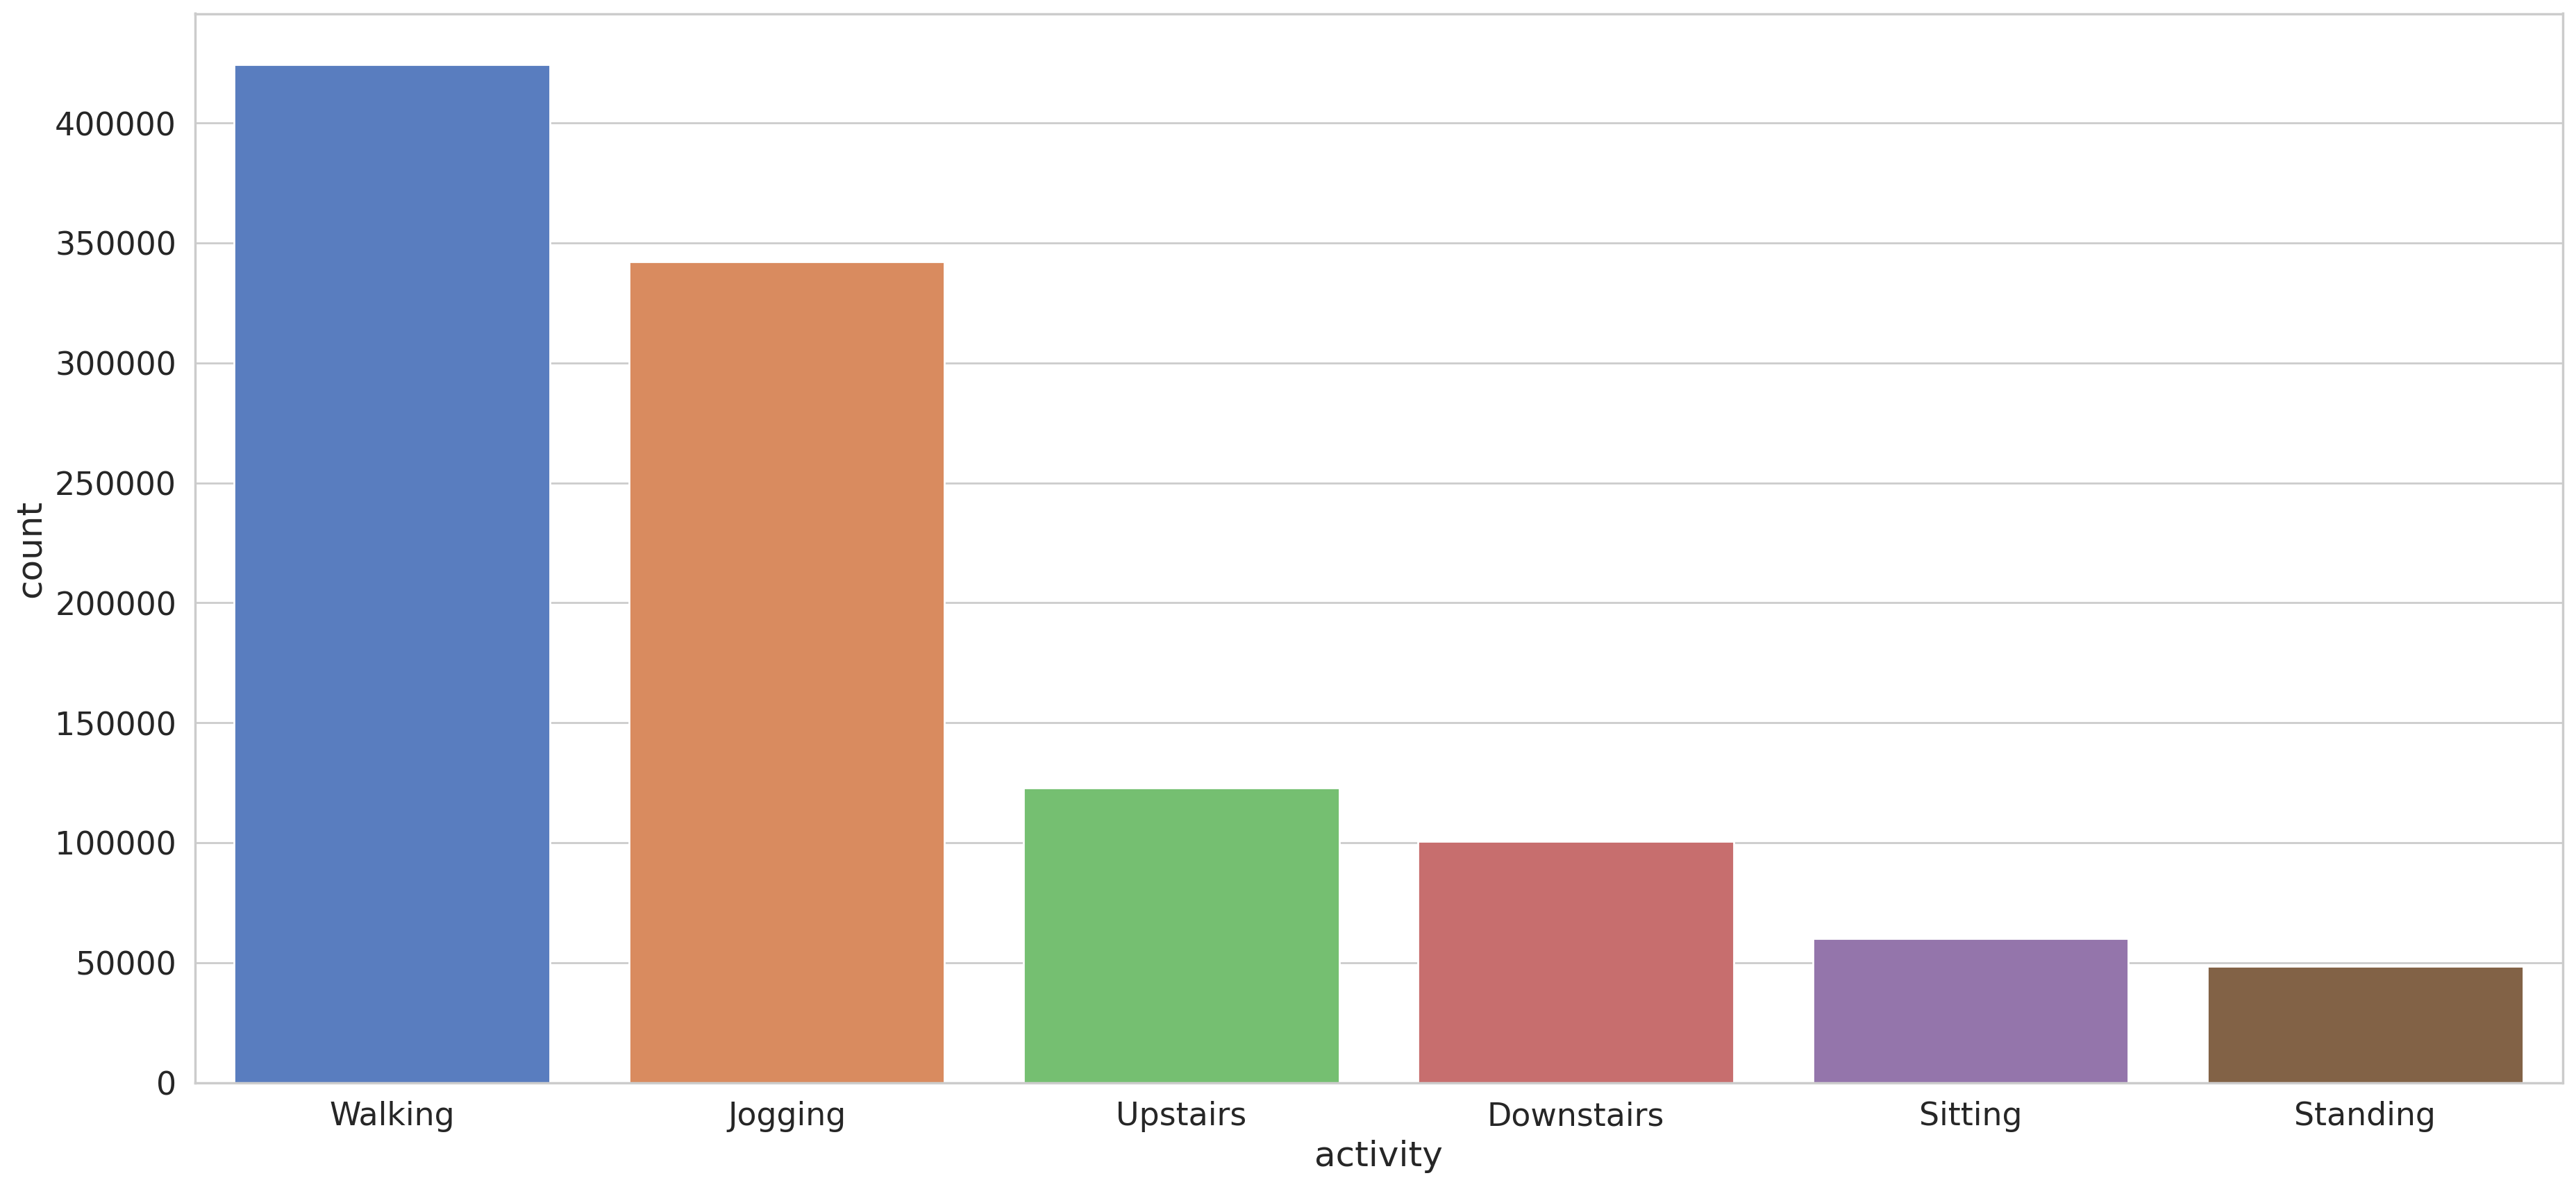

In [6]:
sns.countplot(x = "activity", data = df, order = df.activity.value_counts().index)

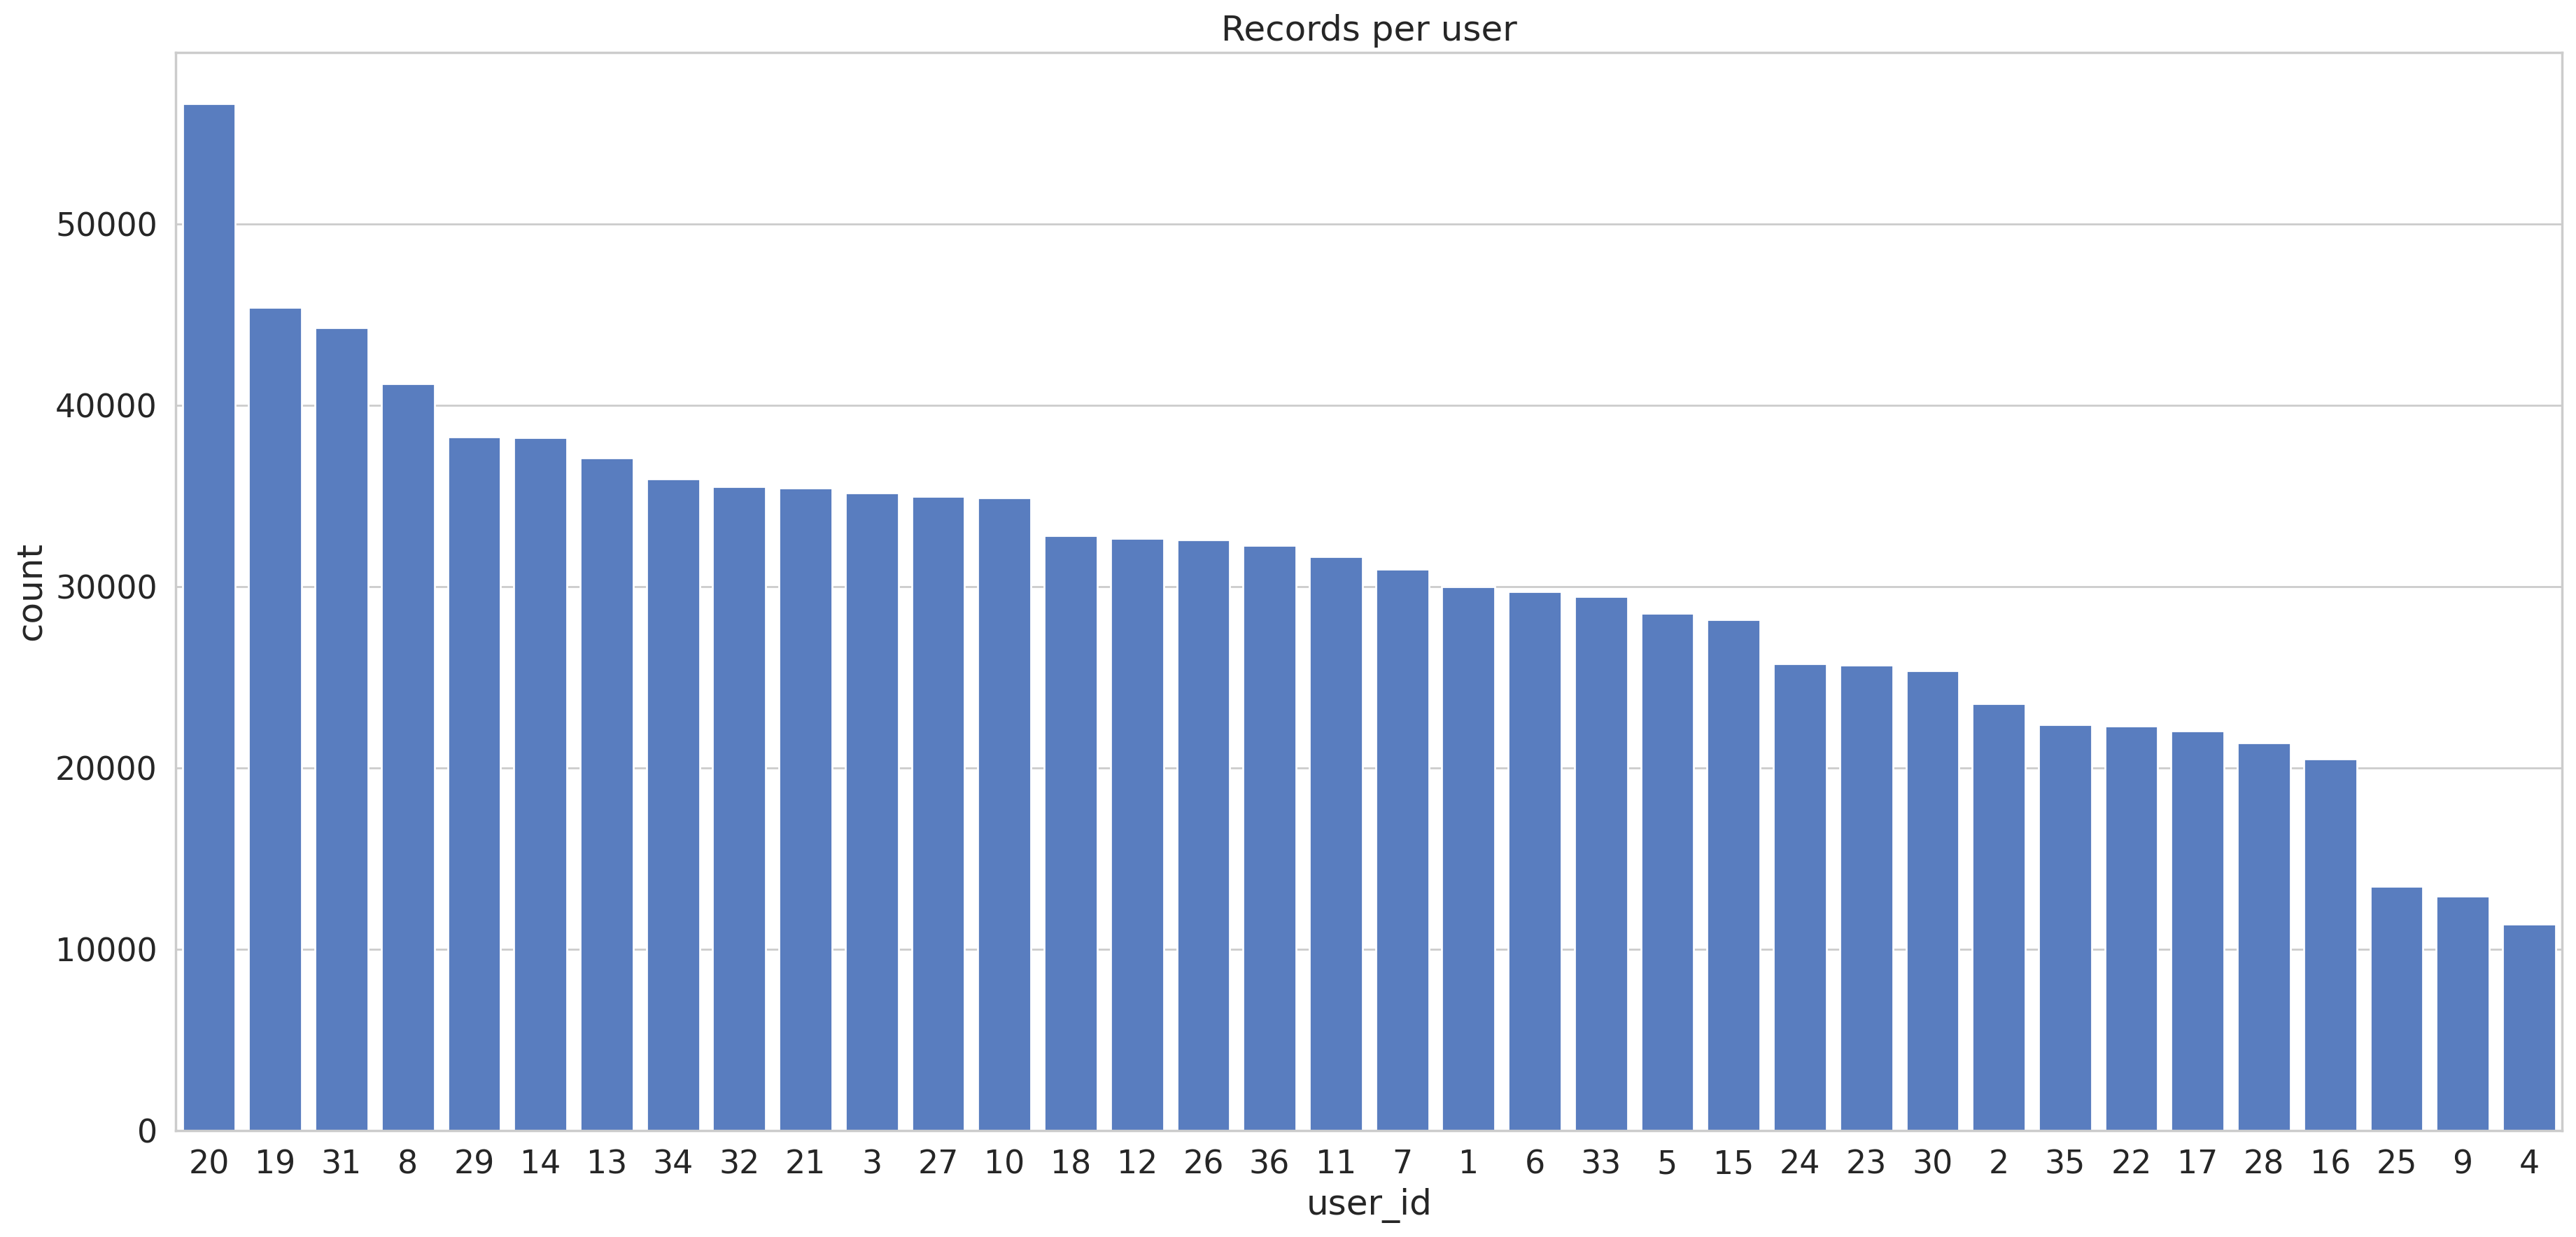

In [7]:
sns.countplot(x = "user_id", data = df, palette = [sns.color_palette()[0]],
              order = df.user_id.value_counts().index)
plt.title("Records per user");


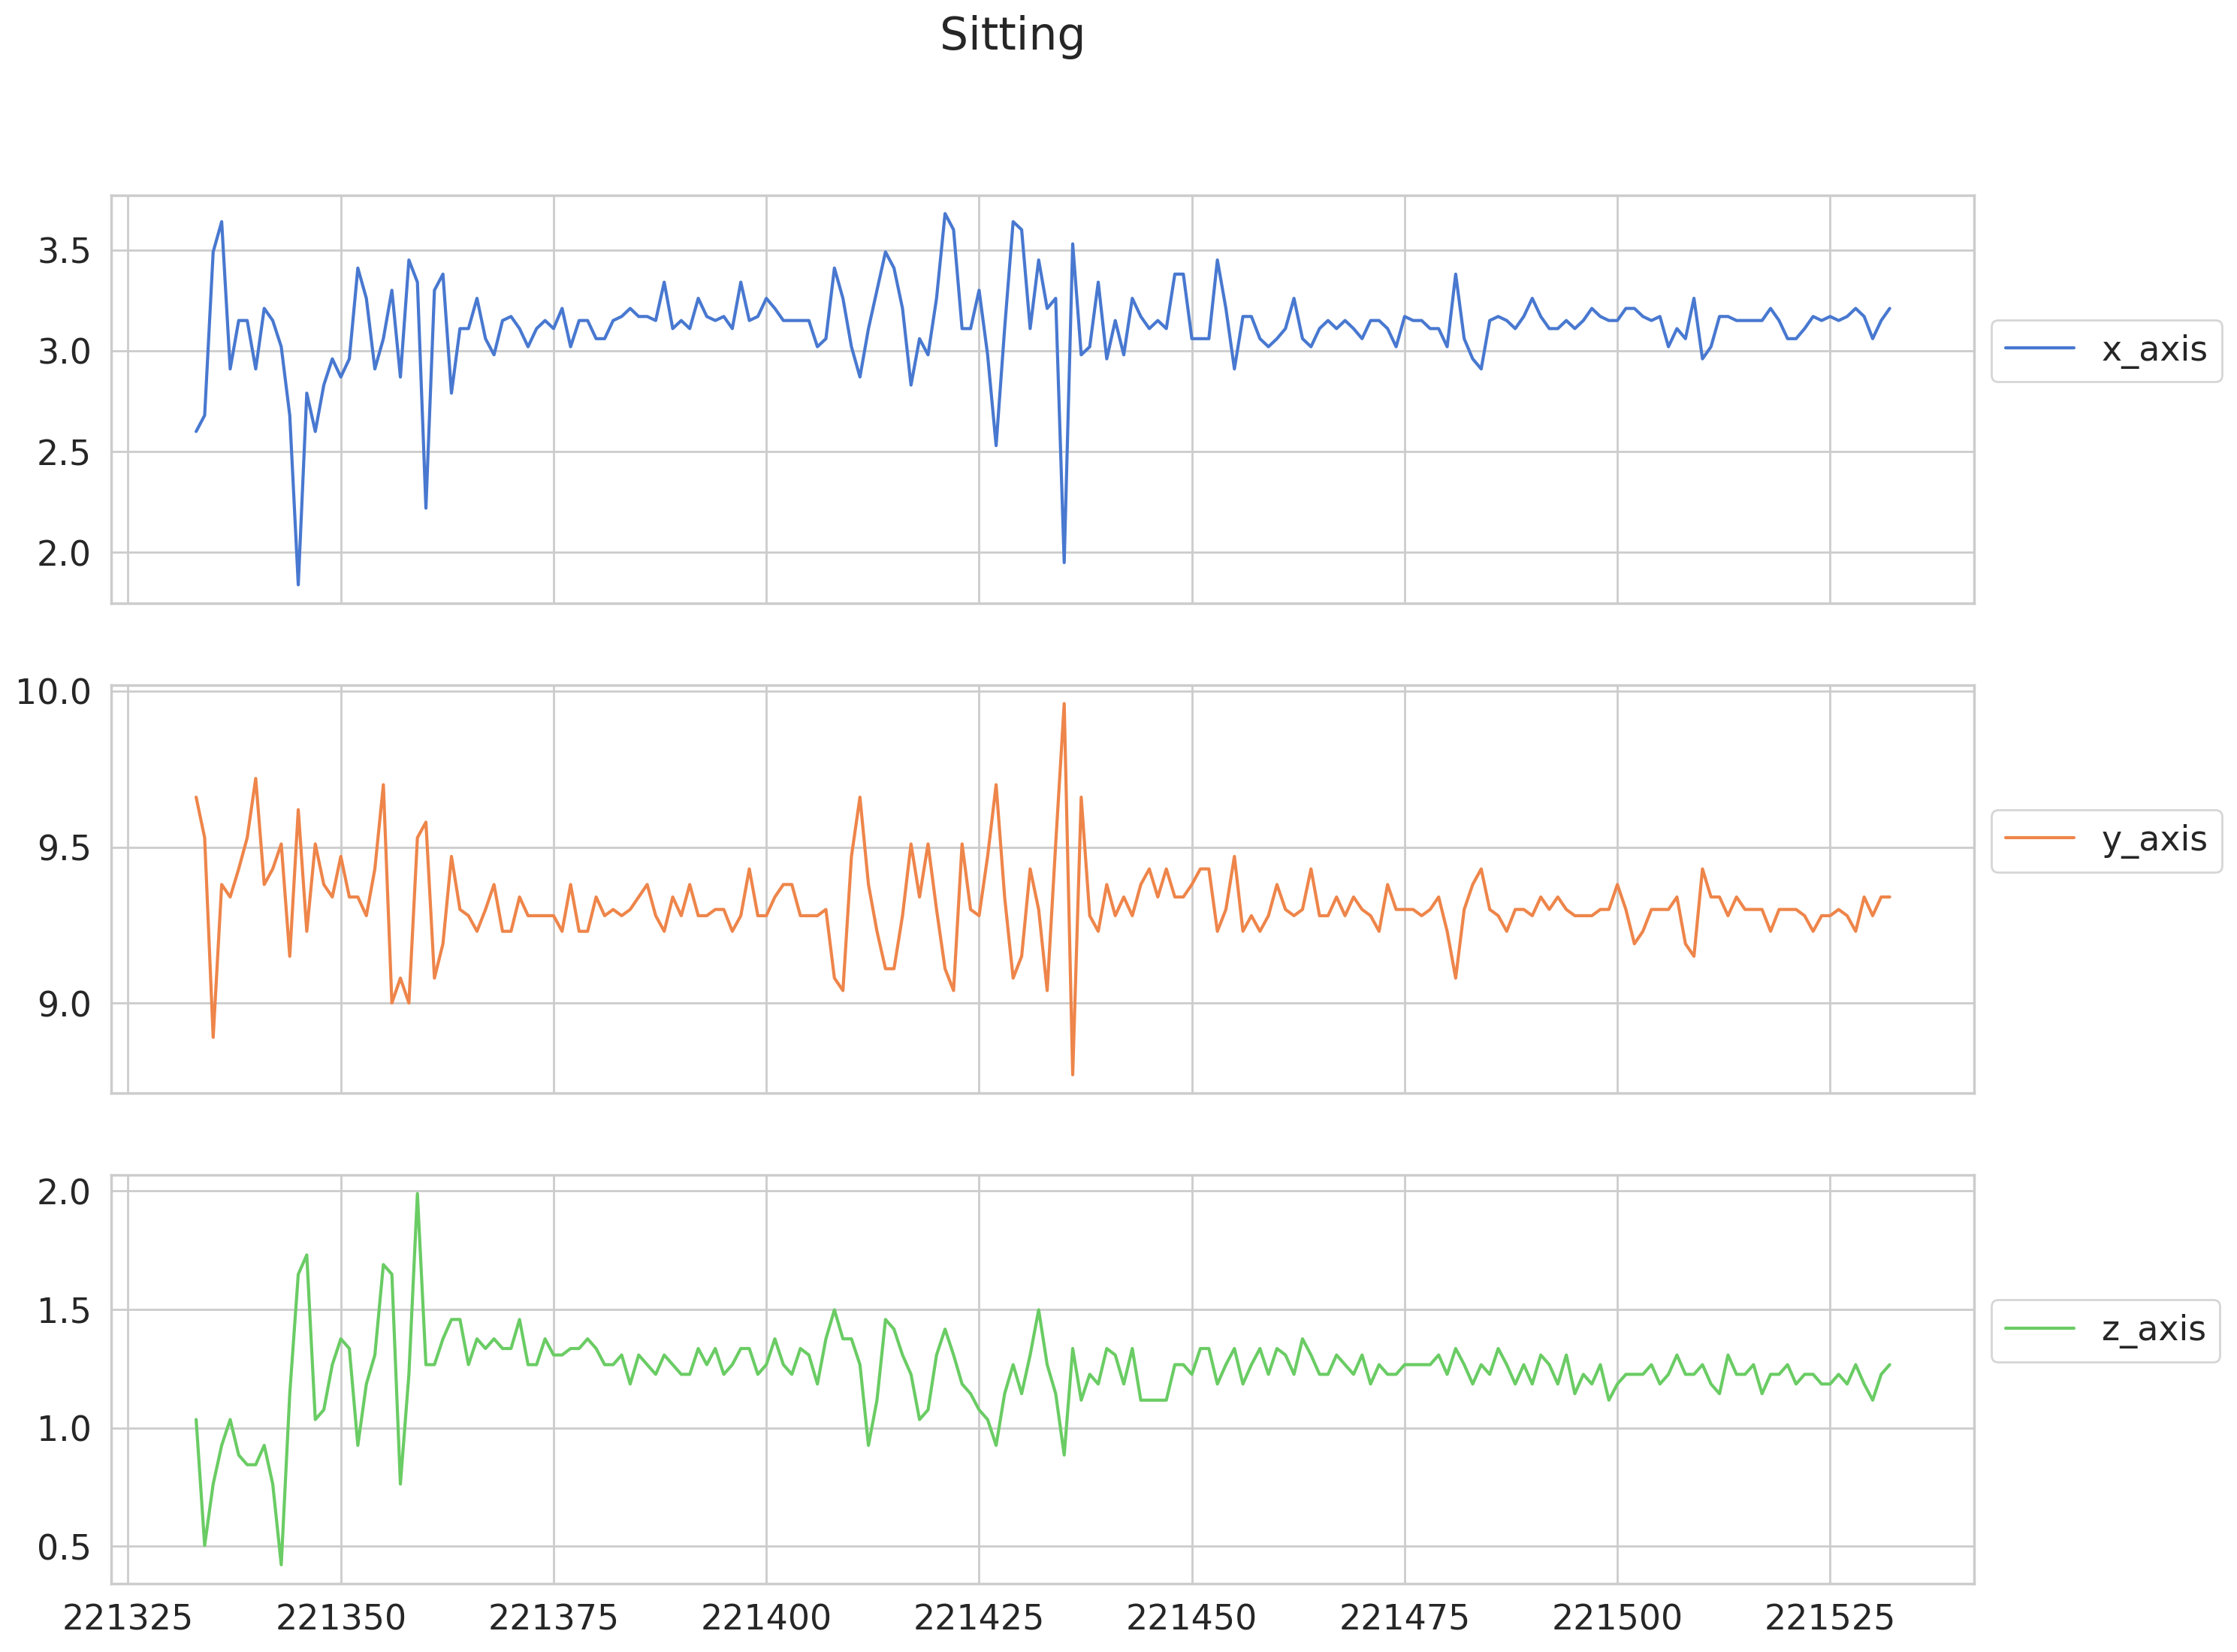

In [8]:

def plot_activity(activity, df):
    data = df[df["activity"] == activity][["x_axis", "y_axis", "z_axis"]][:200]
    axis = data.plot(subplots = True, figsize = (16, 12), title = activity)
    for ax in axis:
        ax.legend(loc = "lower left", bbox_to_anchor = (1.0, 0.5))

plot_activity("Sitting", df)


In [9]:
indexes = df[ (df['activity'] == 'Sitting') | (df['activity'] == 'Standing')].index
df.drop(indexes , inplace=True)


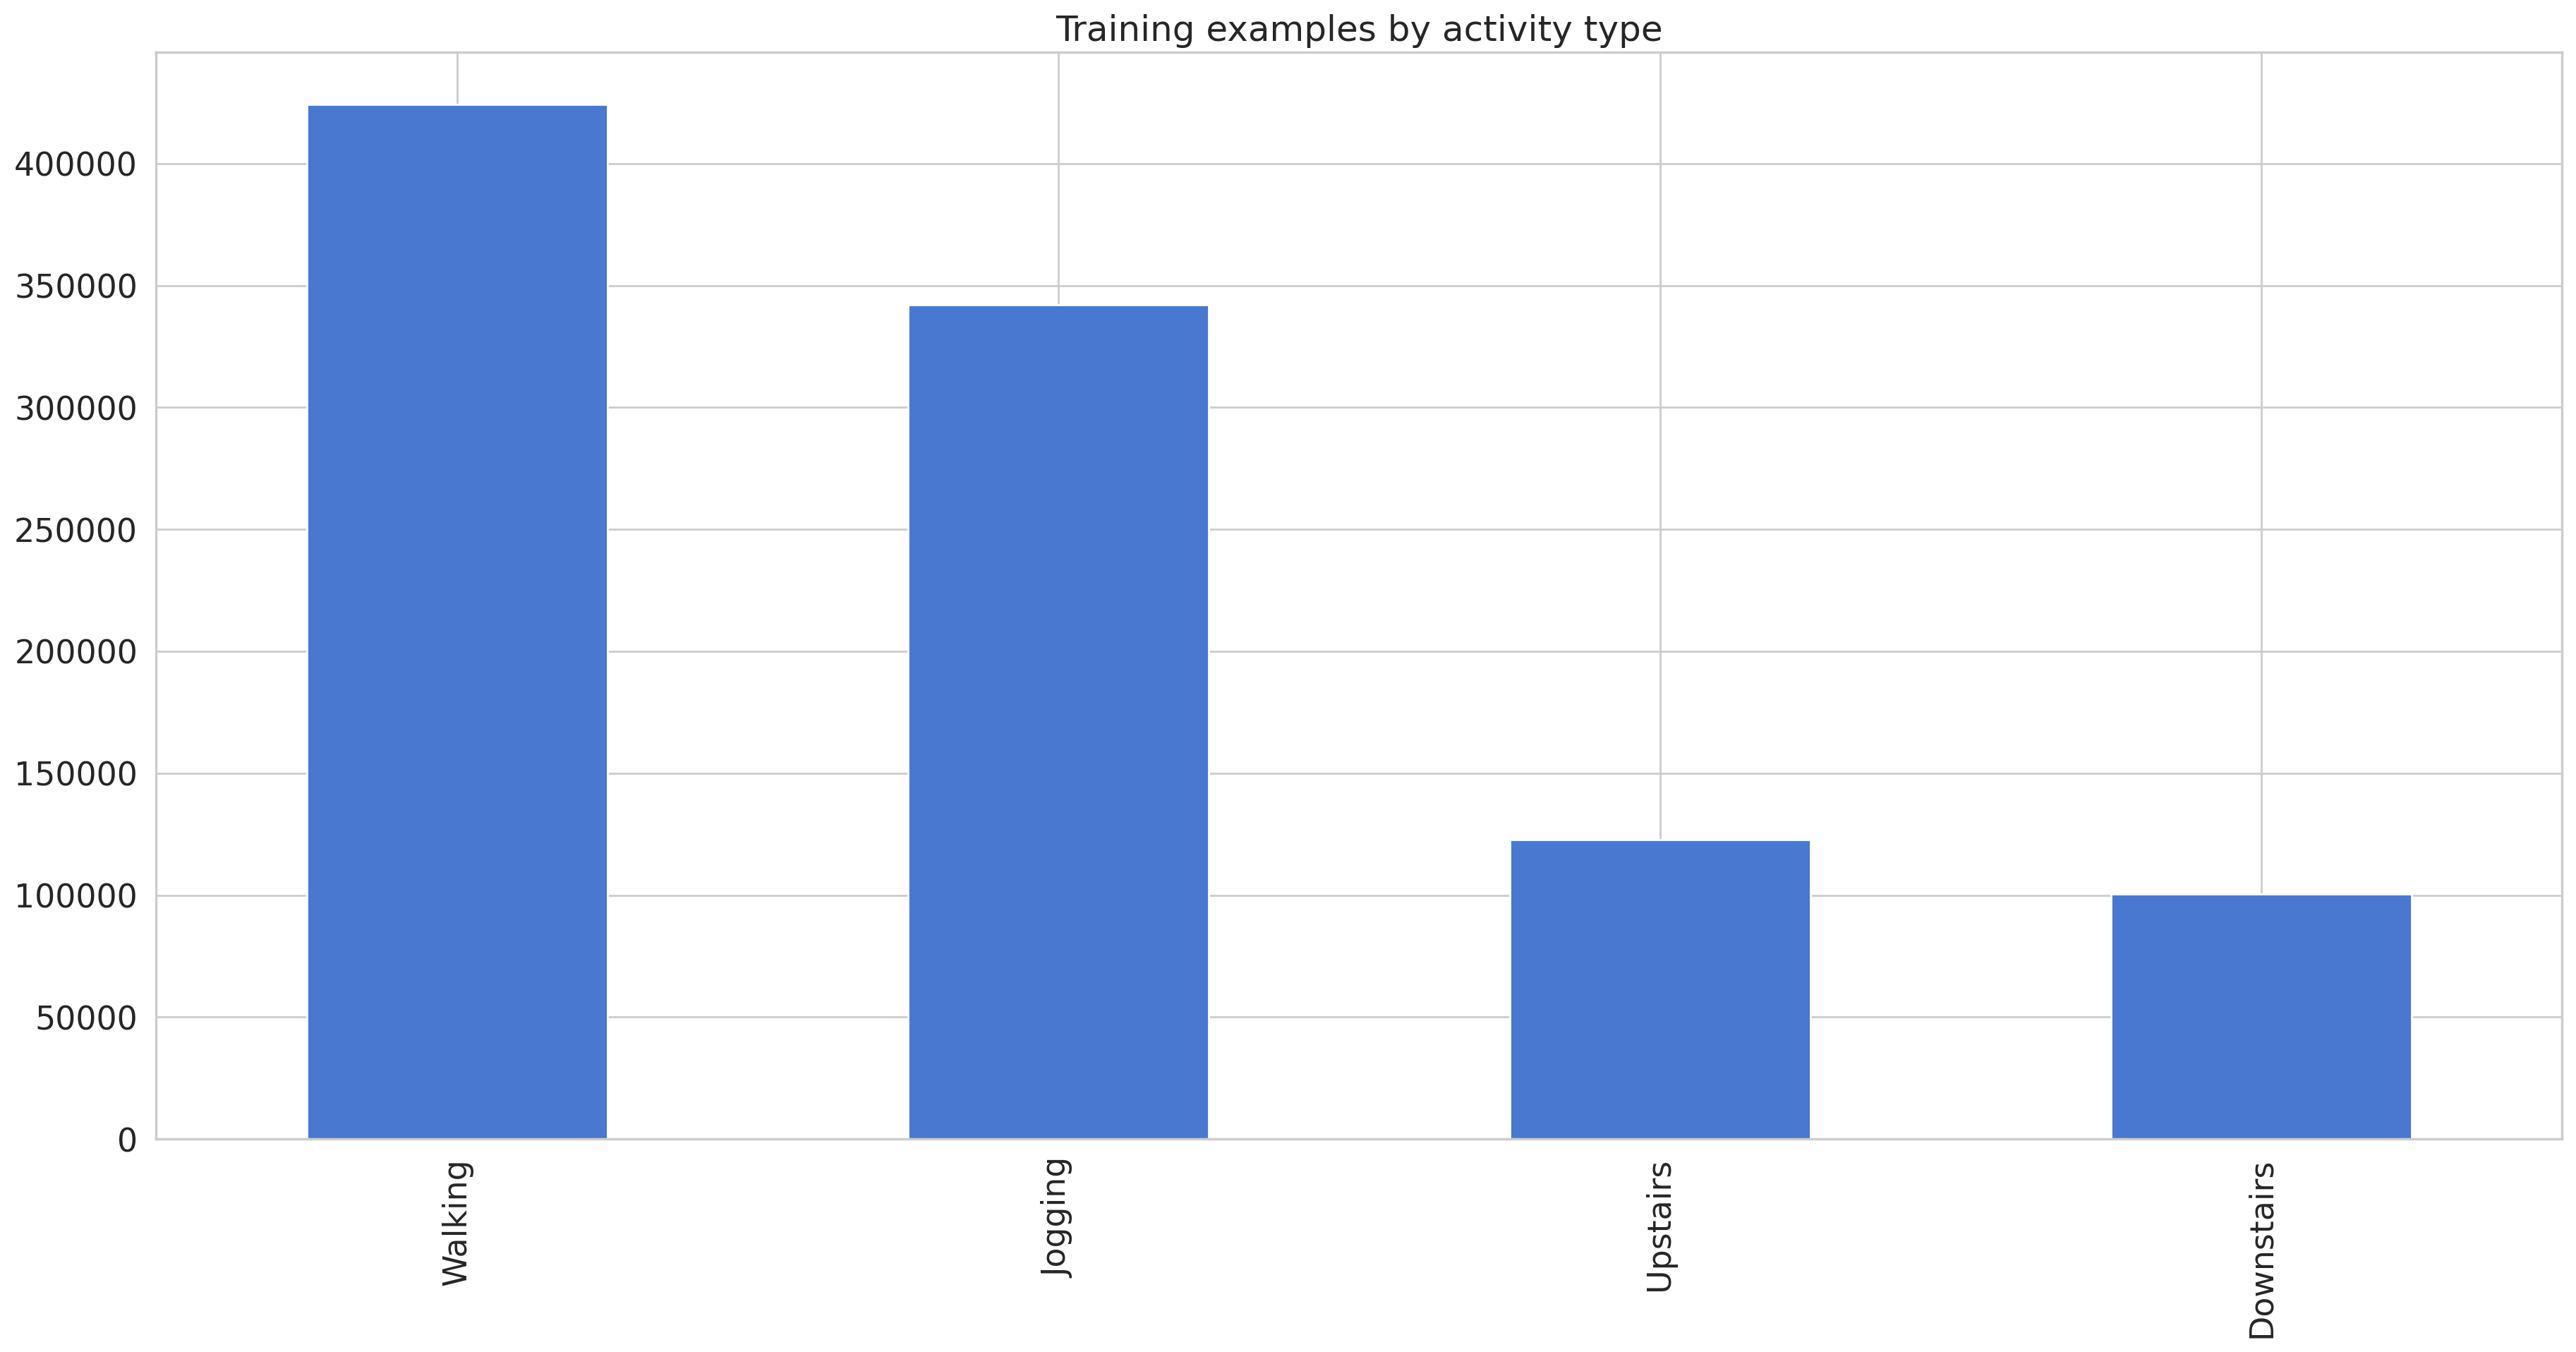

In [10]:
df['activity'].value_counts().plot(kind='bar', title='Training examples by activity type');

random_seed = 42

n_time_steps = 50

n_features = 3

step = 10

n_classes = 6

n_epochs = 50       

batch_size = 1024   

learning_rate = 0.0025

l2_loss = 0.0015


In [11]:
from sklearn.preprocessing import RobustScaler

scale_columns = ["x_axis", "y_axis", "z_axis"]

scaler = RobustScaler()

scaler = scaler.fit(df[scale_columns])

df.loc[:, scale_columns] = scaler.transform(df[scale_columns].to_numpy())
df

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(


user_id    activity        timestamp    x_axis    y_axis    z_axis  \
0             33     Jogging   49105962326000 -0.139064  0.528798  0.162904   
1             33     Jogging   49106062271000  0.627996  0.365980  0.257510   
2             33     Jogging   49106112167000  0.613350  0.322145  0.039629   
3             33     Jogging   49106222305000 -0.128080  1.197291  0.693271   
4             33     Jogging   49106332290000 -0.204969  0.463045  1.573395   
...          ...         ...              ...       ...       ...       ...   
1093534       19  Downstairs  131357151521000 -0.602151 -0.017241  0.635659   
1093535       19  Downstairs  131357191438000 -0.987903  0.155172  0.248370   
1093536       19  Downstairs  131357231630000 -1.235215  0.718391  0.119975   
1093537       19  Downstairs  131357271516000 -1.065860  0.026437 -0.524103   
1093538       19  Downstairs  131357351686000 -0.977151 -0.510345 -0.103137   

         ActivityEncoded  
0                      1  
1                      1  
2                      1  
3                      1  
4                      1  
...                  ...  
1093534                3  
1093535                3  
1093536                3  
1093537                3  
1093538                3  

[989870 rows x 7 columns]

In [12]:
from scipy import stats

def create_dataset(X, y, time_steps=1, step=1):
    Xs, ys = [], []
    for i in range(0, len(X) - time_steps, step):
        v = X.iloc[i:(i + time_steps)].values
        labels = y.iloc[i: i + time_steps]
        Xs.append(v)
        ys.append(stats.mode(labels)[0])
    return np.array(Xs), np.array(ys).reshape(-1, 1)

TIME_STEPS = 50
STEP = 10

X_data, y_data = create_dataset(df[["x_axis", "y_axis", "z_axis"]], df.ActivityEncoded, TIME_STEPS,
                                  STEP)

X_train, X_test,y_train, y_test = train_test_split(X_data, y_data, test_size = 0.2, stratify=  y_data )
X_train, X_val, y_train, y_val  = train_test_split(X_train, y_train, test_size = 0.2, stratify=  y_train )
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(63348, 50, 3) (63348, 1)
(19797, 50, 3) (19797, 1)


In [13]:
from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder(handle_unknown = "ignore", sparse = False)
enc = enc.fit(y_train)

y_train_hot = enc.transform(y_train)
y_test_hot = enc.transform(y_test)
y_val_hot = enc.transform(y_val)

print(X_train.shape, y_train_hot.shape, X_test.shape, y_test_hot.shape)

(63348, 50, 3) (63348, 4) (19797, 50, 3) (19797, 4)


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [14]:

batch_size = 1024
learning_rate = 0.0025
l2_loss = 0.0015
n_timesteps,n_features,n_outputs= X_train.shape[1],X_train.shape[2],y_train_hot.shape[1]
n_timesteps,n_features,n_outputs

(50, 3, 4)

# LSTM1


In [ ]:
model = Sequential()
# RNN layer
model.add(LSTM(units = 128, input_shape = (X_train.shape[1], X_train.shape[2])))
# Dropout layer
model.add(Dropout(0.5))
# Dense layer with ReLu
model.add(Dense(units = 64, activation='relu'))
# Softmax layer
model.add(Dense(y_train_hot.shape[1], activation = 'softmax'))
# Compile model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 128)               67584     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 dense_1 (Dense)             (None, 4)                 260       
                                                                 
Total params: 76100 (297.27 KB)
Trainable params: 76100 (297.27 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
# validation_split = 0.1
batch_size = 1024

train_epochs = 10

history = model.fit(X_train, y_train_hot, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_data = (X_val, y_val_hot), shuffle=True)


Epoch 1/10
62/62 [==============================] - 46s 715ms/step - loss: 0.9821 - accuracy: 0.6358 - val_loss: 0.7388 - val_accuracy: 0.7340
Epoch 2/10
62/62 [==============================] - 40s 653ms/step - loss: 0.6426 - accuracy: 0.7696 - val_loss: 0.5926 - val_accuracy: 0.7820
Epoch 3/10
62/62 [==============================] - 42s 685ms/step - loss: 0.5605 - accuracy: 0.7916 - val_loss: 0.5062 - val_accuracy: 0.8088
Epoch 4/10
62/62 [==============================] - 41s 651ms/step - loss: 0.4927 - accuracy: 0.8126 - val_loss: 0.4469 - val_accuracy: 0.8324
Epoch 5/10
62/62 [==============================] - 43s 700ms/step - loss: 0.4275 - accuracy: 0.8355 - val_loss: 0.4096 - val_accuracy: 0.8456
Epoch 6/10
62/62 [==============================] - 39s 632ms/step - loss: 0.3883 - accuracy: 0.8526 - val_loss: 0.3536 - val_accuracy: 0.8683
Epoch 7/10
62/62 [==============================] - 41s 667ms/step - loss: 0.3403 - accuracy: 0.8724 - val_loss: 0.3110 - val_accuracy: 0.8820

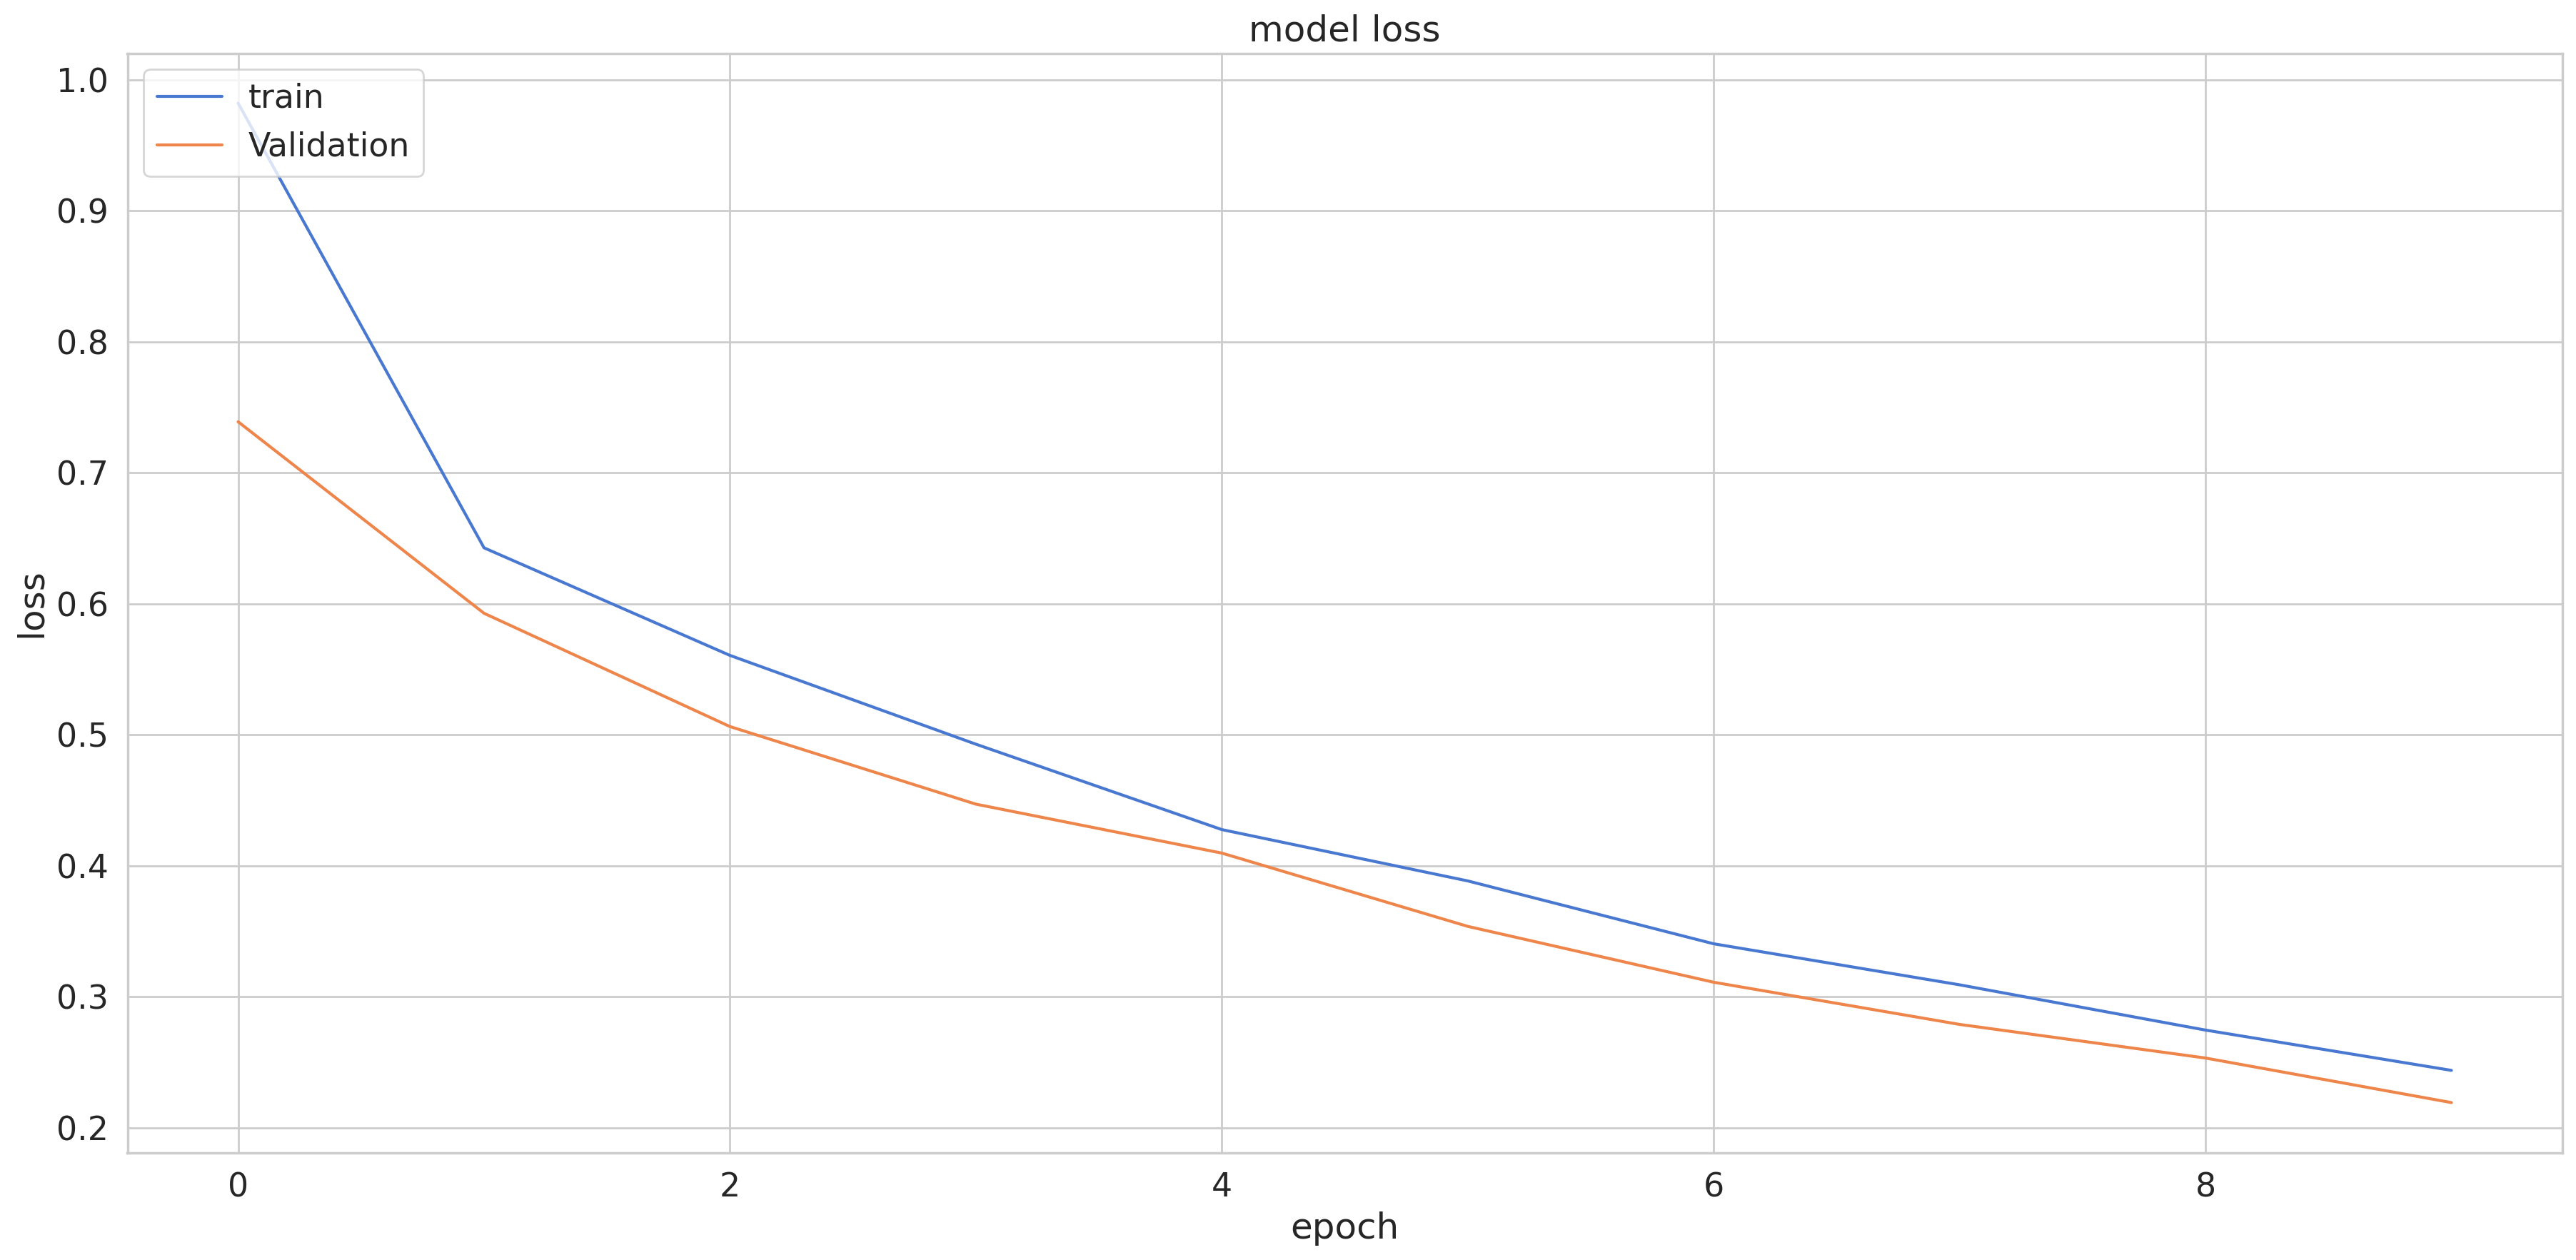

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

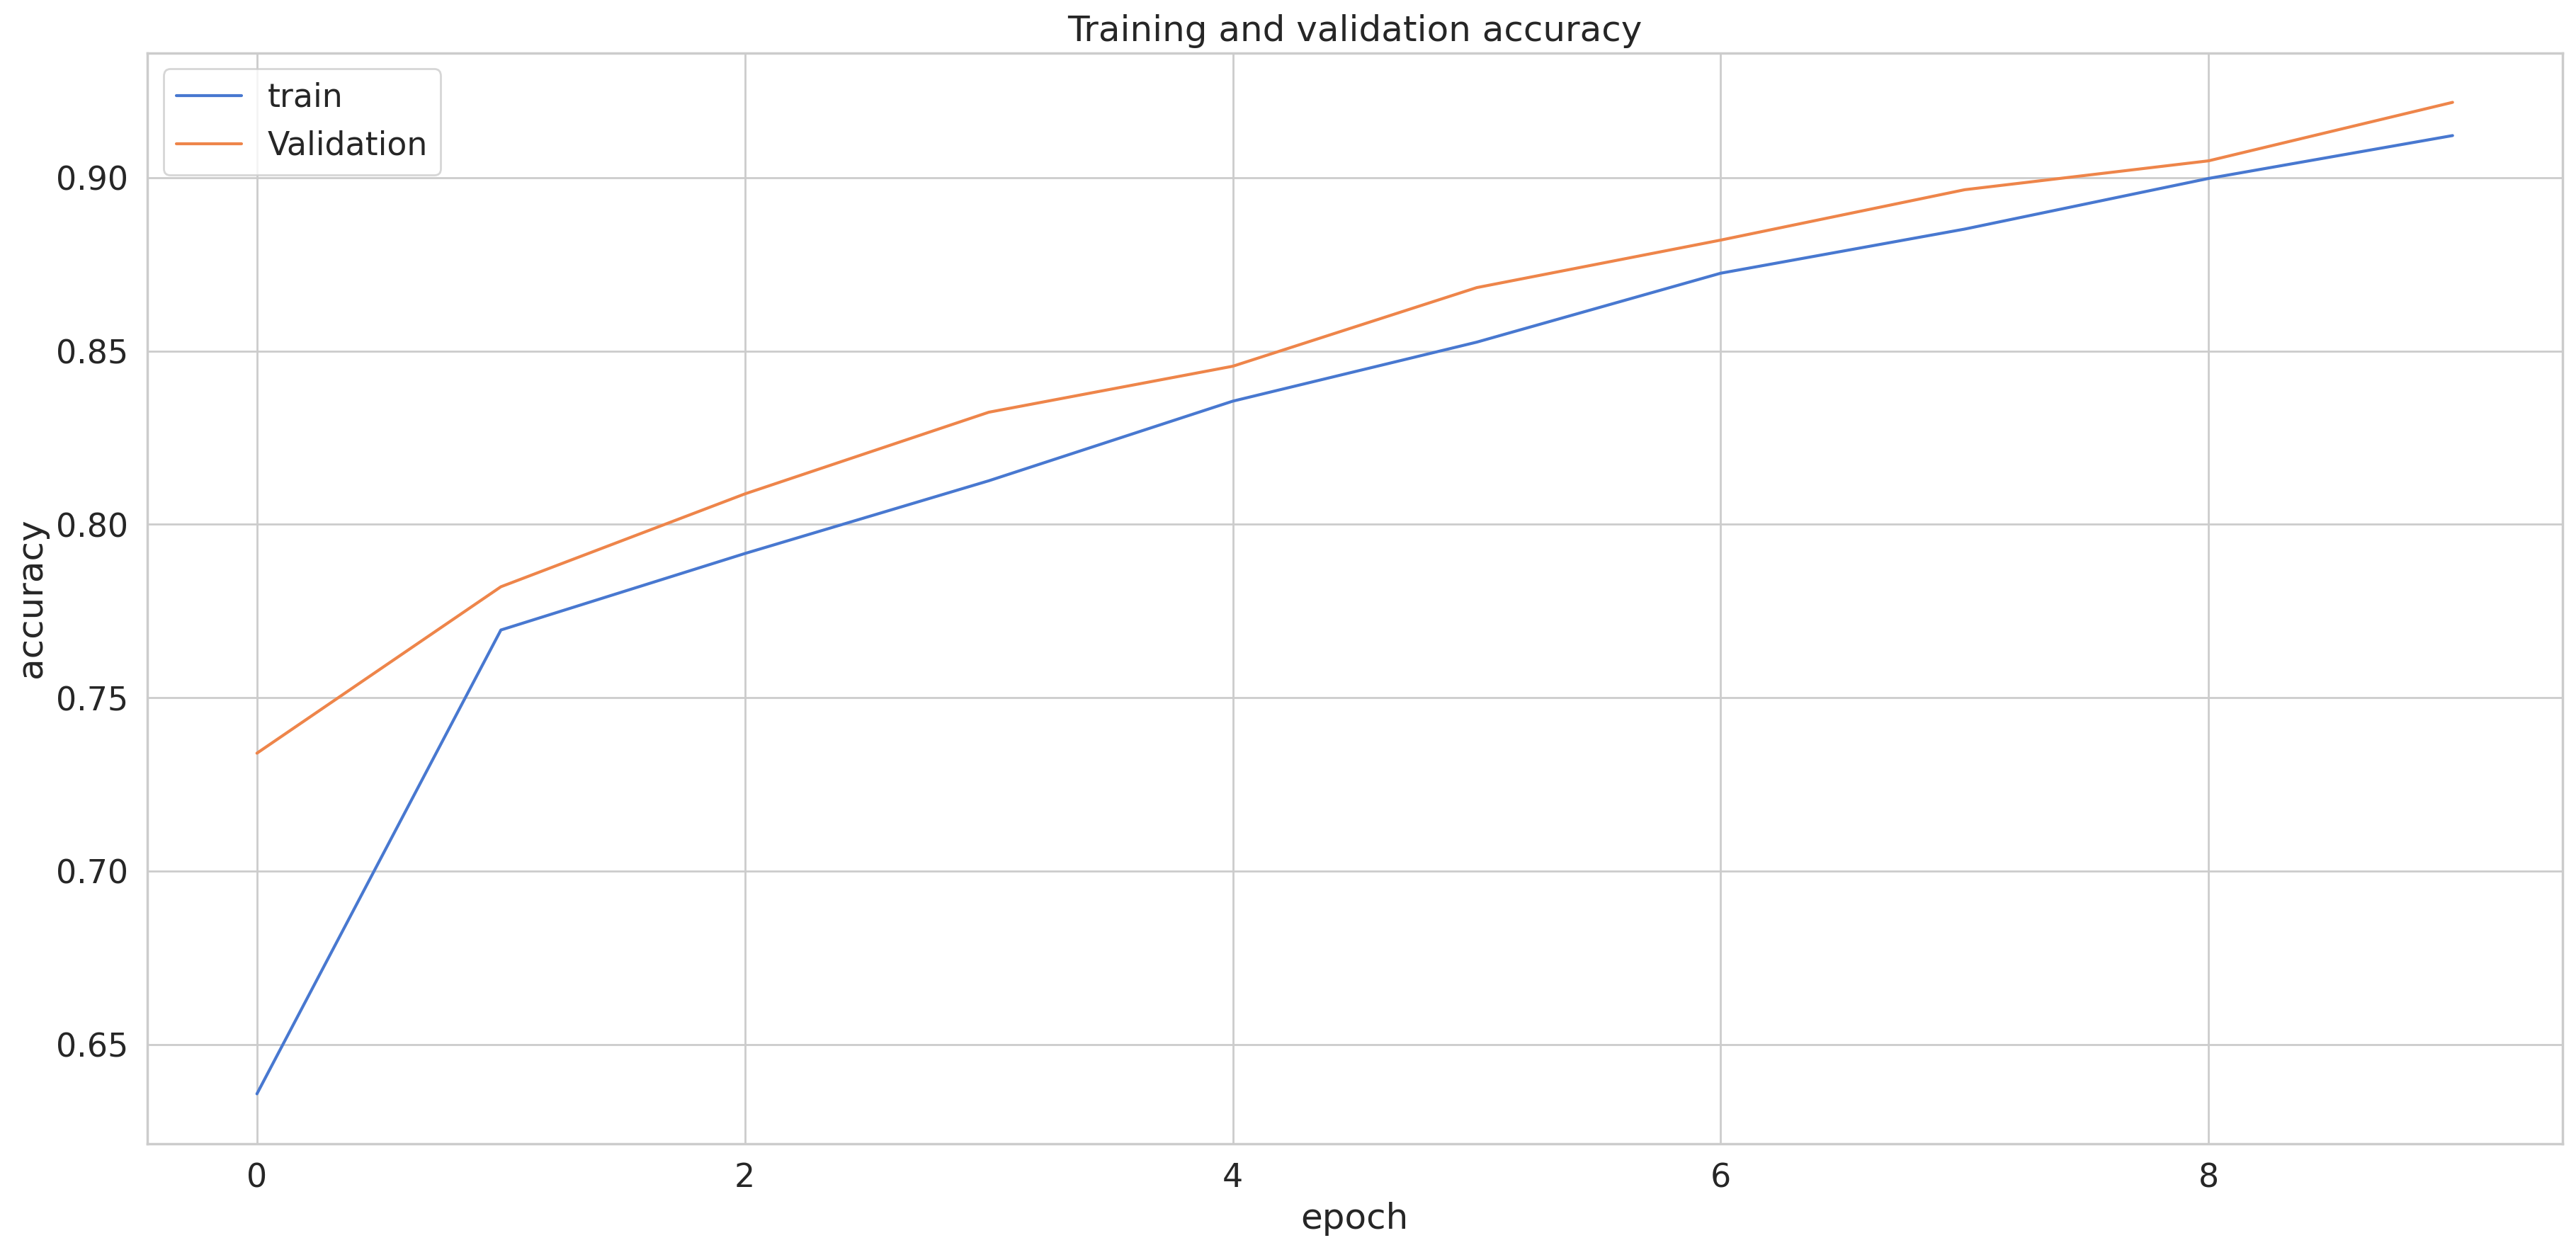

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

619/619 [==============================] - 13s 21ms/step
f1_score =  0.9235967151189222
0.9232206900035359
              precision    recall  f1-score   support

           0       0.96      0.96      0.96      8490
           1       0.98      0.98      0.98      6843
           2       0.80      0.79      0.79      2459
           3       0.73      0.77      0.75      2005

    accuracy                           0.92     19797
   macro avg       0.87      0.87      0.87     19797
weighted avg       0.92      0.92      0.92     19797



<Axes: >

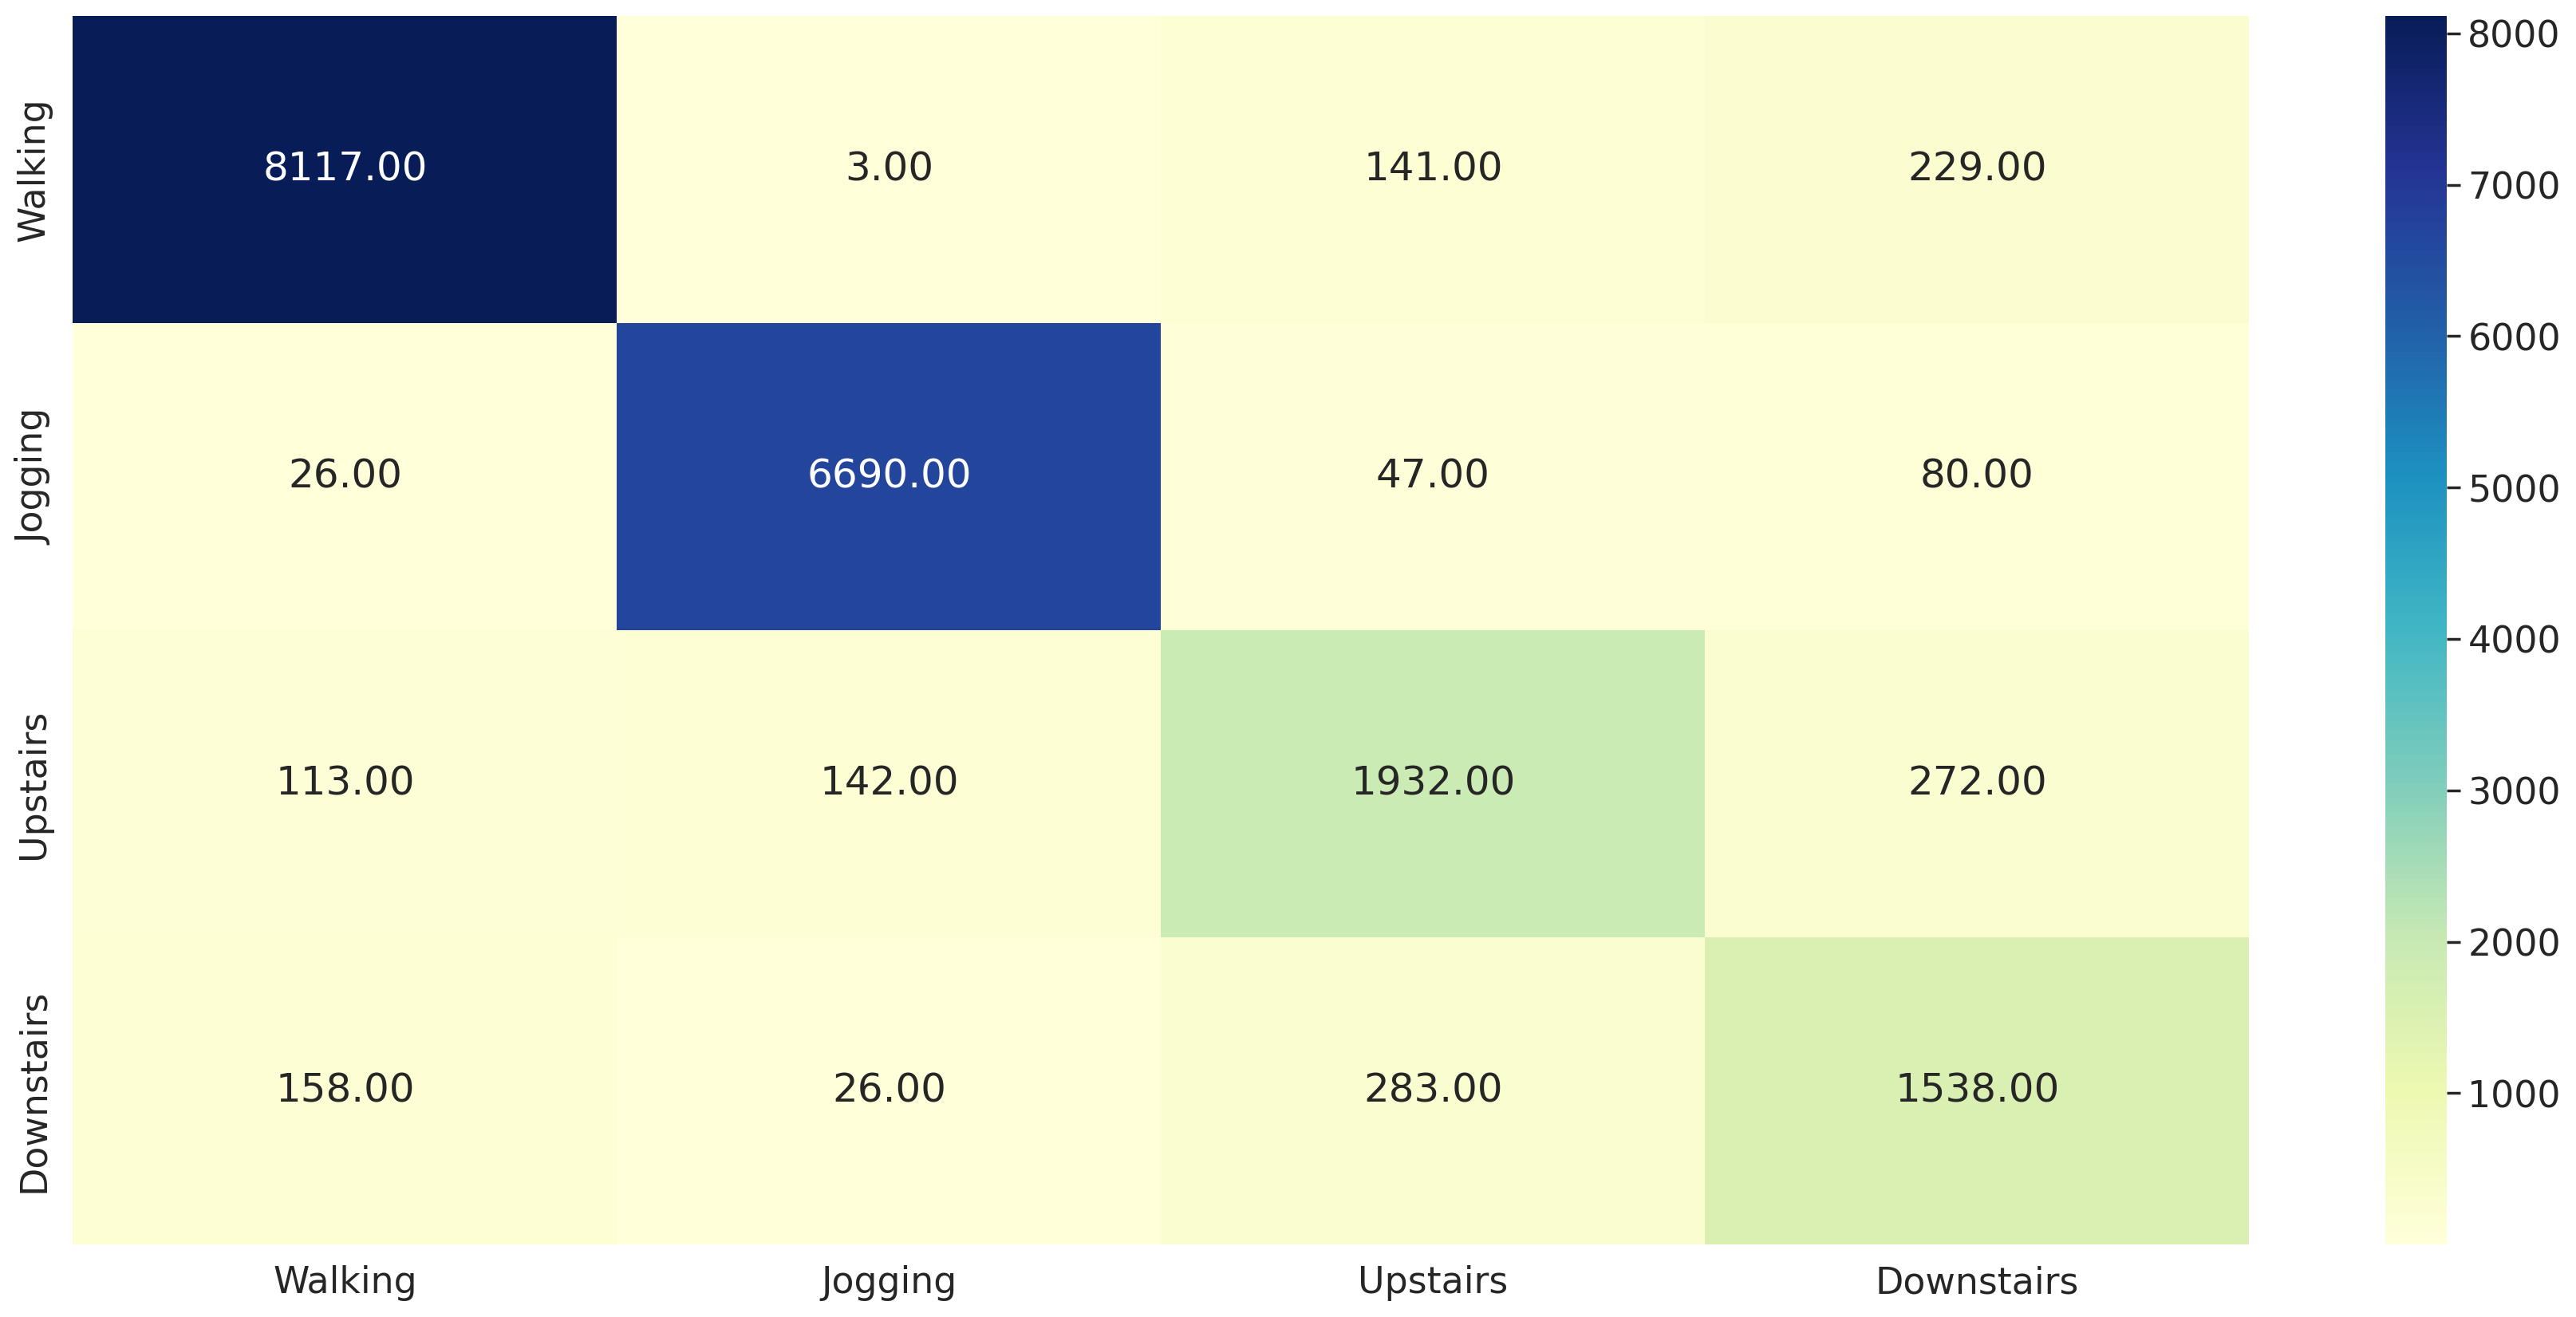

In [ ]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

y_pred=model.predict(X_test)
y_pred = np.argmax(y_pred, axis=-1)
y_true = np.argmax(y_test_hot, axis=-1)

LABELS = ['Walking', 'Jogging', 'Upstairs', 'Downstairs']
cm=confusion_matrix(y_true,y_pred)

#print(cm)
print('f1_score = ', f1_score(y_test, y_pred, average='weighted'))
print(accuracy_score(y_true,y_pred))
print(classification_report(y_true,y_pred))
sns.heatmap(cm, cmap="YlGnBu", xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt = '.2f')

# LSTM2

In [ ]:
model = Sequential()
# RNN layer
model.add(LSTM(units = 128, return_sequences=True, input_shape = (X_train.shape[1], X_train.shape[2])))
# Dropout layer
model.add(Dropout(0.5))
# Dense layer with ReLu
model.add(LSTM(128))
model.add(Dropout(0.5))

model.add(Dense(units = 64, activation='relu'))
# Softmax layer
model.add(Dense(y_train_hot.shape[1], activation = 'softmax'))
# Compile model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 50, 128)           67584     
                                                                 
 dropout_1 (Dropout)         (None, 50, 128)           0         
                                                                 
 lstm_2 (LSTM)               (None, 128)               131584    
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dense_3 (Dense)             (None, 4)                 260       
                                                                 
Total params: 207684 (811.27 KB)
Trainable params: 207

In [ ]:
# validation_split = 0.1
batch_size = 128

train_epochs = 10
history = model.fit(X_train, y_train_hot, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_data = (X_val, y_val_hot), shuffle=True)


Epoch 1/10
495/495 [==============================] - 195s 385ms/step - loss: 0.5843 - accuracy: 0.7859 - val_loss: 0.4161 - val_accuracy: 0.8454
Epoch 2/10
495/495 [==============================] - 175s 353ms/step - loss: 0.2917 - accuracy: 0.8965 - val_loss: 0.2091 - val_accuracy: 0.9268
Epoch 3/10
495/495 [==============================] - 173s 350ms/step - loss: 0.1835 - accuracy: 0.9383 - val_loss: 0.1337 - val_accuracy: 0.9543
Epoch 4/10
495/495 [==============================] - 172s 348ms/step - loss: 0.1459 - accuracy: 0.9529 - val_loss: 0.1335 - val_accuracy: 0.9552
Epoch 5/10
495/495 [==============================] - 166s 336ms/step - loss: 0.1193 - accuracy: 0.9615 - val_loss: 0.1019 - val_accuracy: 0.9664
Epoch 6/10
495/495 [==============================] - 173s 351ms/step - loss: 0.1010 - accuracy: 0.9673 - val_loss: 0.0862 - val_accuracy: 0.9718
Epoch 7/10
495/495 [==============================] - 173s 350ms/step - loss: 0.0874 - accuracy: 0.9711 - val_loss: 0.0825 -

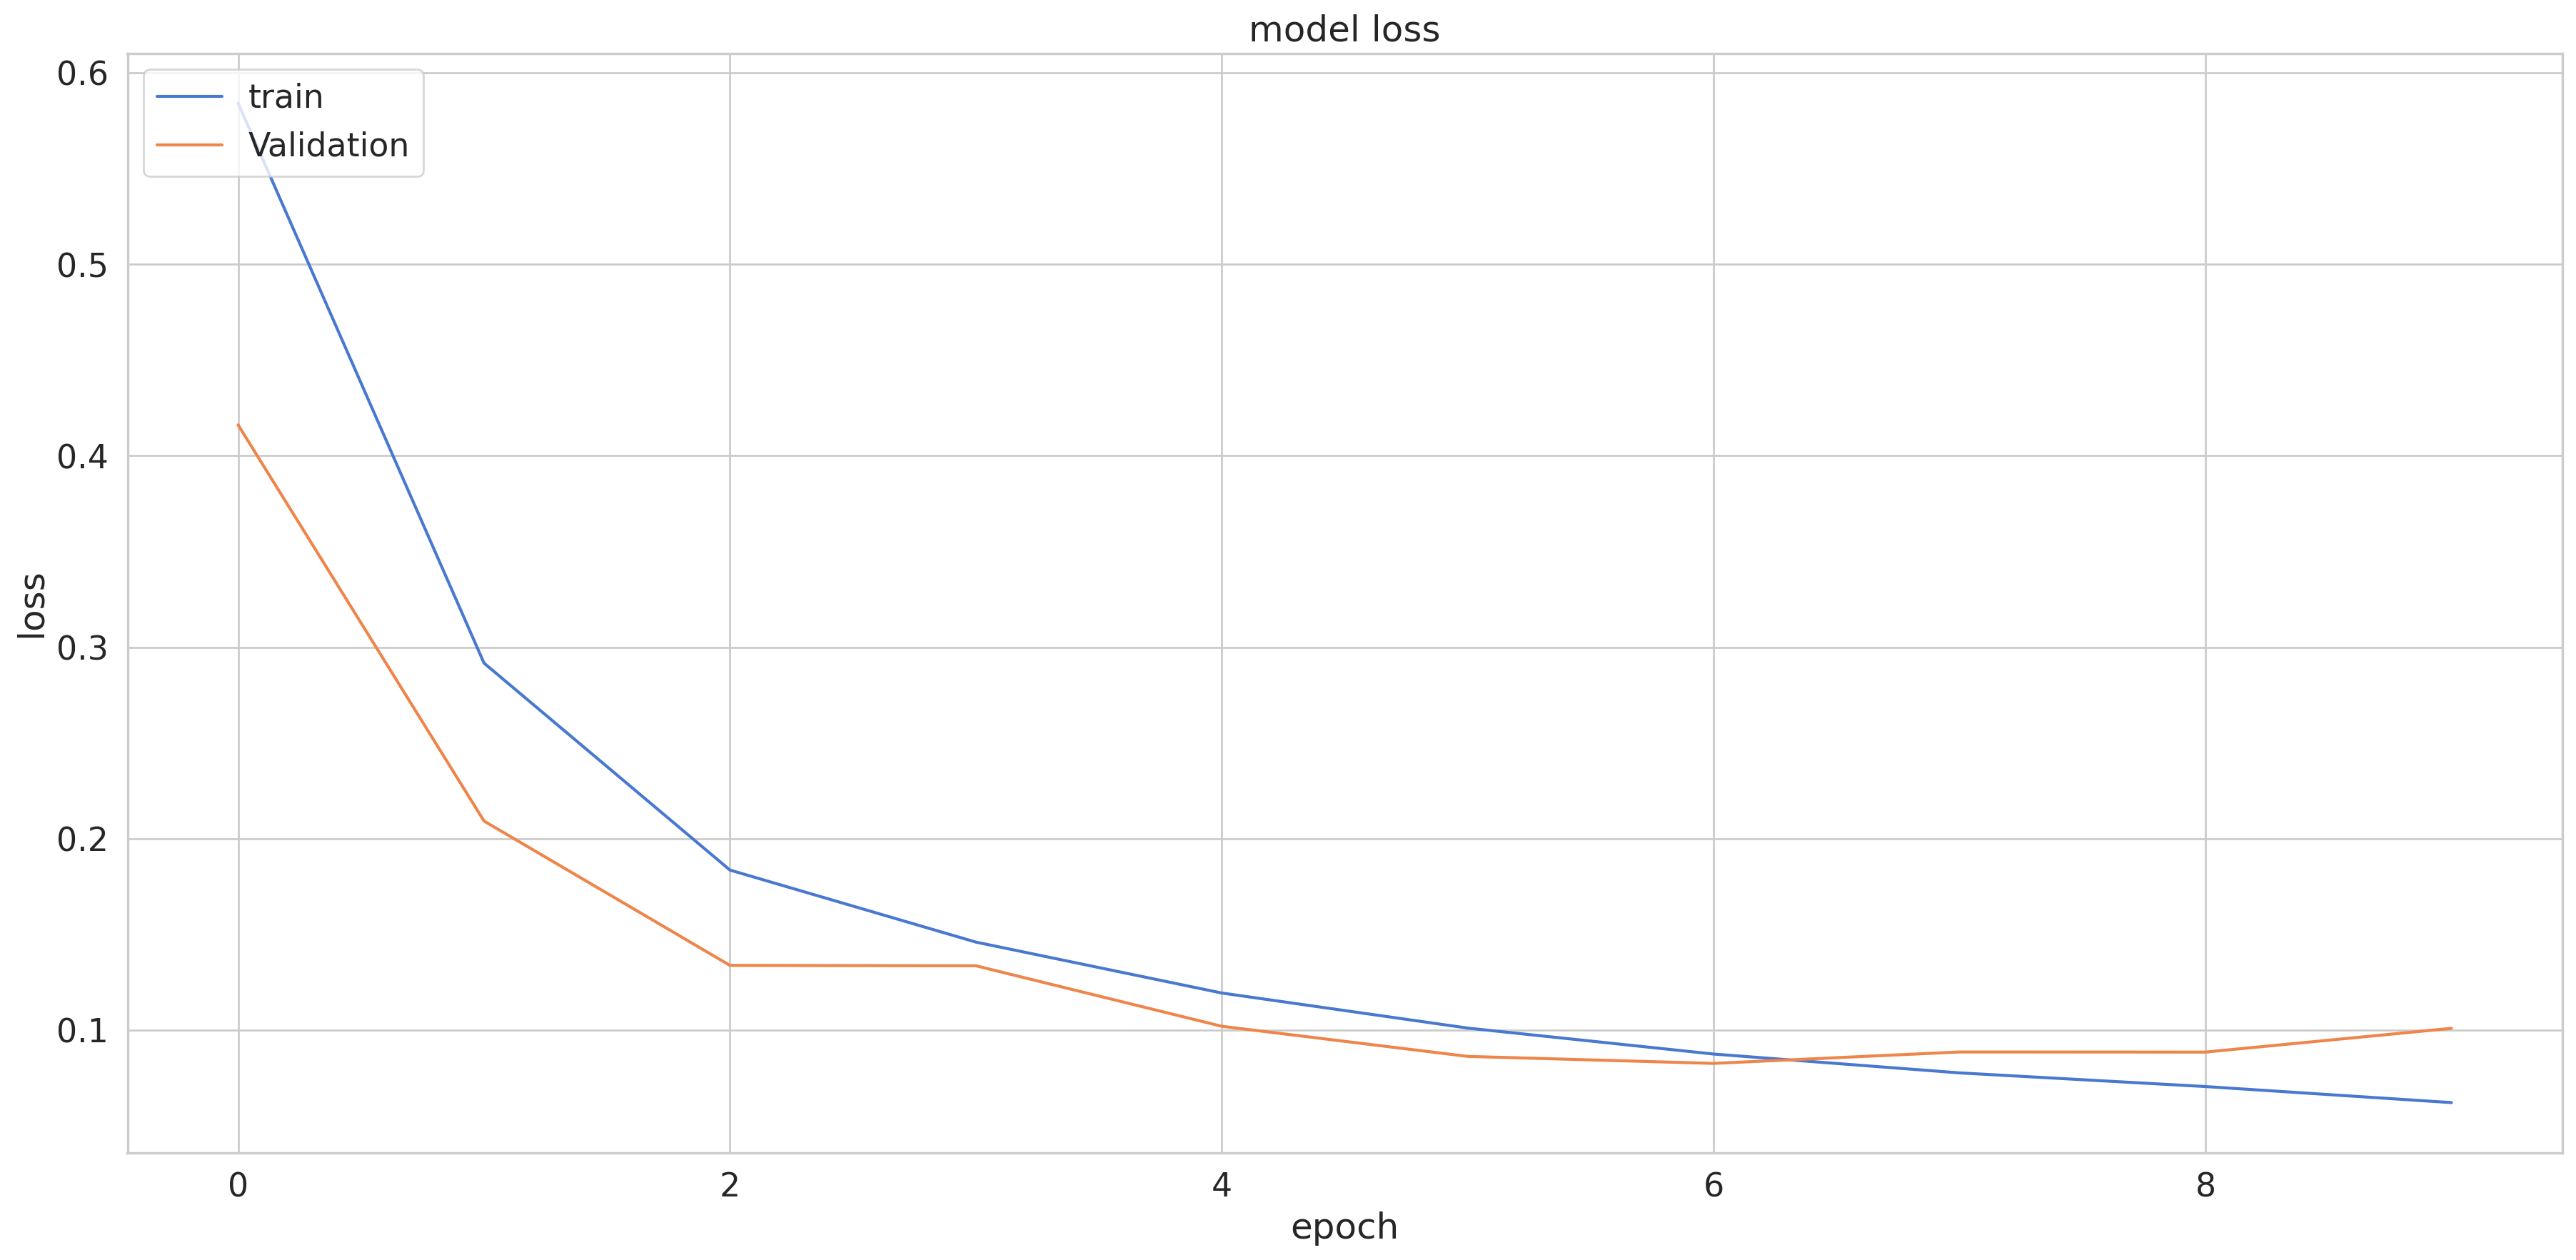

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

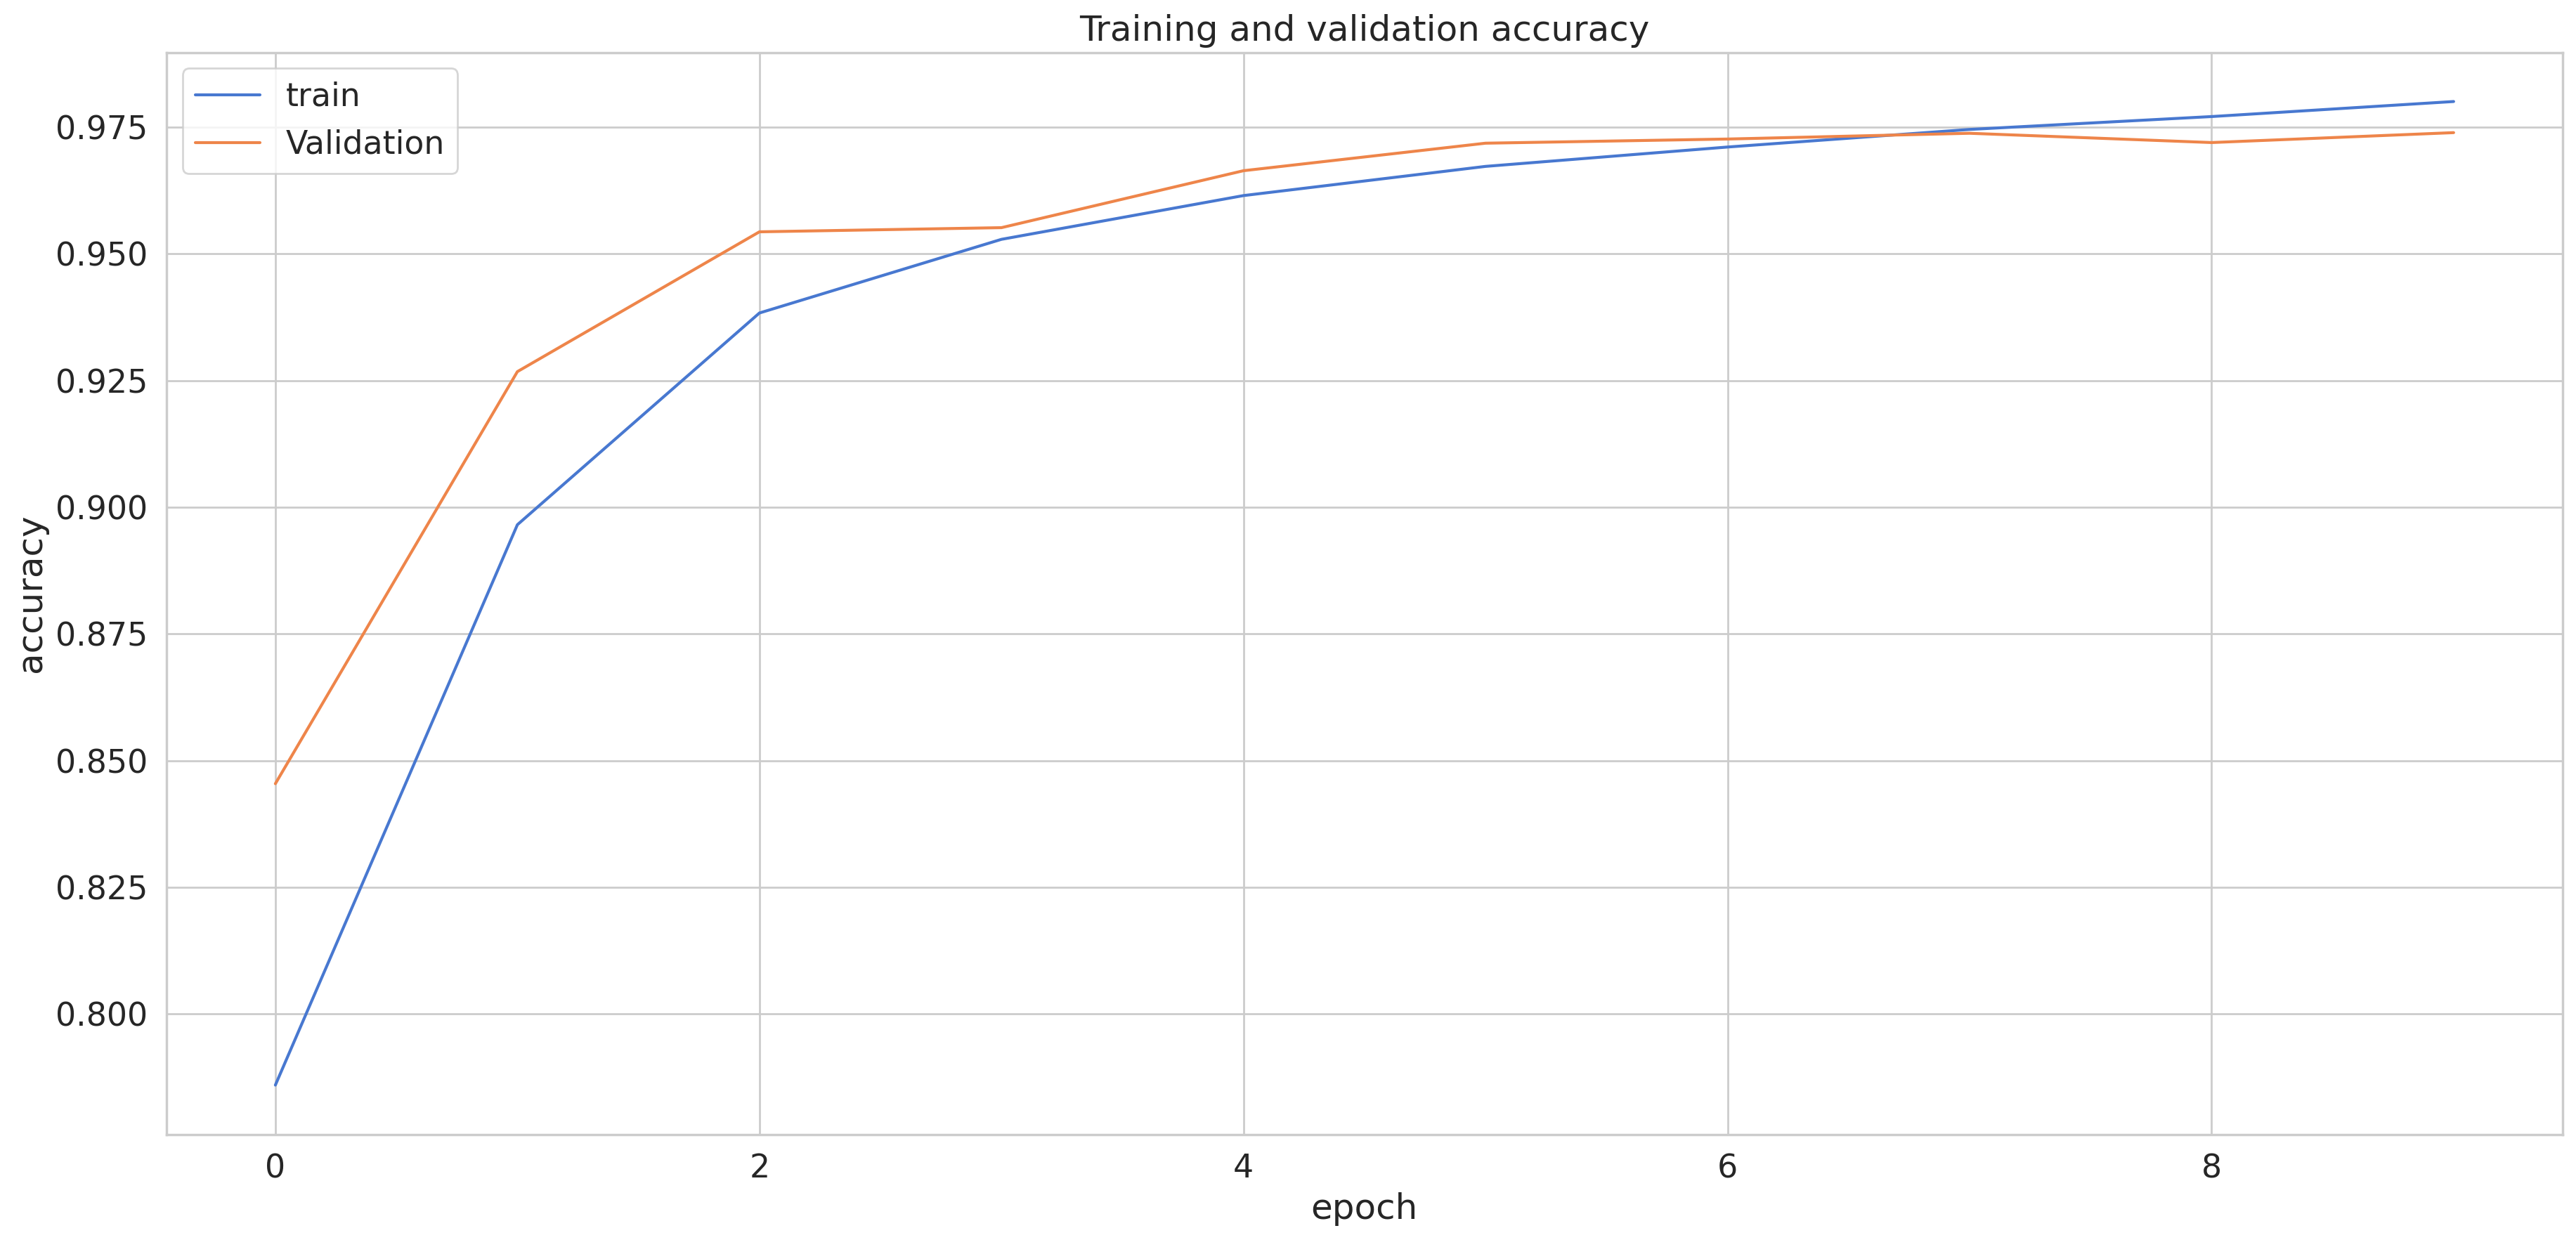

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

619/619 [==============================] - 35s 55ms/step
f1_score =  0.9786966492685265
0.9786836389351922
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      8490
           1       0.99      0.99      0.99      6843
           2       0.93      0.96      0.95      2459
           3       0.95      0.92      0.94      2005

    accuracy                           0.98     19797
   macro avg       0.97      0.97      0.97     19797
weighted avg       0.98      0.98      0.98     19797



<Axes: >

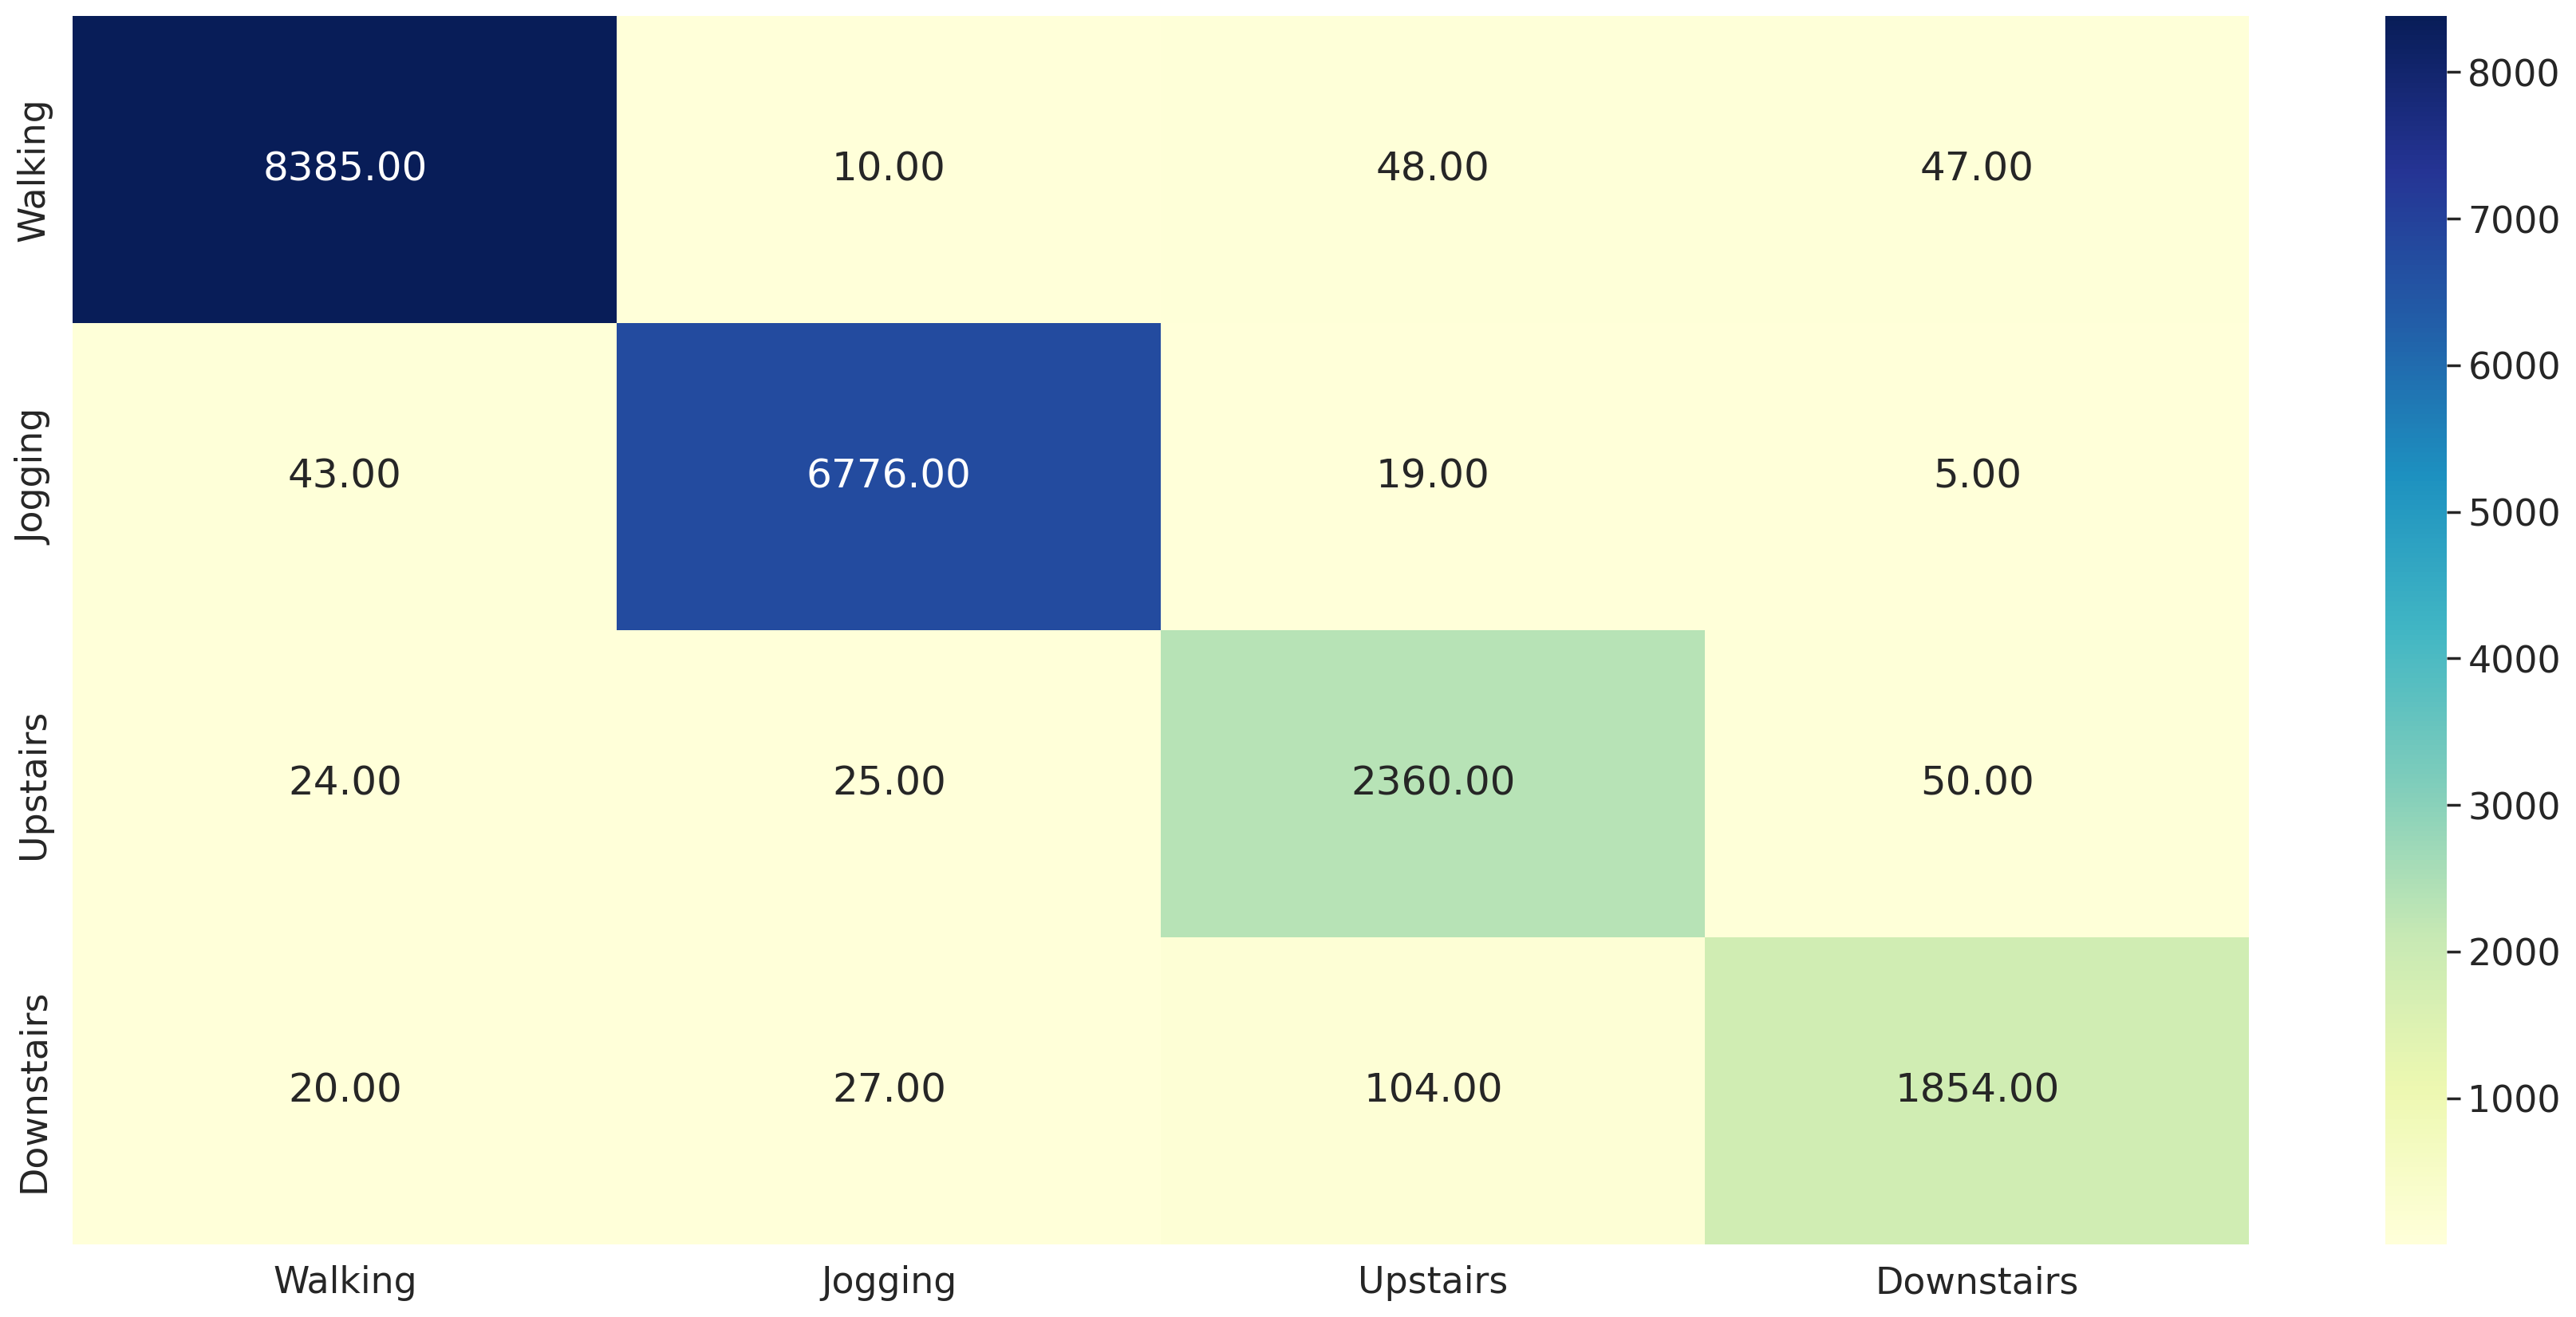

In [ ]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

y_pred=model.predict(X_test)
y_pred = np.argmax(y_pred, axis=-1)
y_true = np.argmax(y_test_hot, axis=-1)

LABELS = ['Walking', 'Jogging', 'Upstairs', 'Downstairs']
cm=confusion_matrix(y_true,y_pred)

#print(cm)
print('f1_score = ', f1_score(y_test, y_pred, average='weighted'))
print(accuracy_score(y_true,y_pred))
print(classification_report(y_true,y_pred))
sns.heatmap(cm, cmap="YlGnBu", xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt = '.2f')

# LSTM3

In [ ]:
model = Sequential()
# RNN layer
model.add(LSTM(units = 128, return_sequences=True, input_shape = (X_train.shape[1], X_train.shape[2])))
# Dropout layer
model.add(Dropout(0.5))

model.add(LSTM(128,return_sequences=True))
model.add(Dropout(0.5))

model.add(LSTM(128))
model.add(Dropout(0.5))
# Dense layer with ReLu
model.add(Dense(units = 64, activation='relu'))
# Softmax layer
model.add(Dense(y_train_hot.shape[1], activation = 'softmax'))
# Compile model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 50, 128)           67584     
                                                                 
 dropout_3 (Dropout)         (None, 50, 128)           0         
                                                                 
 lstm_4 (LSTM)               (None, 50, 128)           131584    
                                                                 
 dropout_4 (Dropout)         (None, 50, 128)           0         
                                                                 
 lstm_5 (LSTM)               (None, 128)               131584    
                                                                 
 dropout_5 (Dropout)         (None, 128)               0         
                                                                 
 dense_4 (Dense)             (None, 64)               

In [ ]:
# validation_split = 0.1
batch_size = 128

train_epochs = 10
history = model.fit(X_train, y_train_hot, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_data = (X_val, y_val_hot), shuffle=True)


Epoch 1/10
495/495 [==============================] - 296s 586ms/step - loss: 0.6122 - accuracy: 0.7783 - val_loss: 0.4292 - val_accuracy: 0.8402
Epoch 2/10
495/495 [==============================] - 288s 582ms/step - loss: 0.3044 - accuracy: 0.8904 - val_loss: 0.2278 - val_accuracy: 0.9196
Epoch 3/10
495/495 [==============================] - 289s 584ms/step - loss: 0.1823 - accuracy: 0.9392 - val_loss: 0.1450 - val_accuracy: 0.9509
Epoch 4/10
495/495 [==============================] - 286s 578ms/step - loss: 0.1413 - accuracy: 0.9548 - val_loss: 0.1183 - val_accuracy: 0.9609
Epoch 5/10
495/495 [==============================] - 286s 578ms/step - loss: 0.1131 - accuracy: 0.9632 - val_loss: 0.1020 - val_accuracy: 0.9650
Epoch 6/10
495/495 [==============================] - 287s 579ms/step - loss: 0.0967 - accuracy: 0.9681 - val_loss: 0.0920 - val_accuracy: 0.9709
Epoch 7/10
495/495 [==============================] - 288s 583ms/step - loss: 0.0814 - accuracy: 0.9725 - val_loss: 0.0669 -

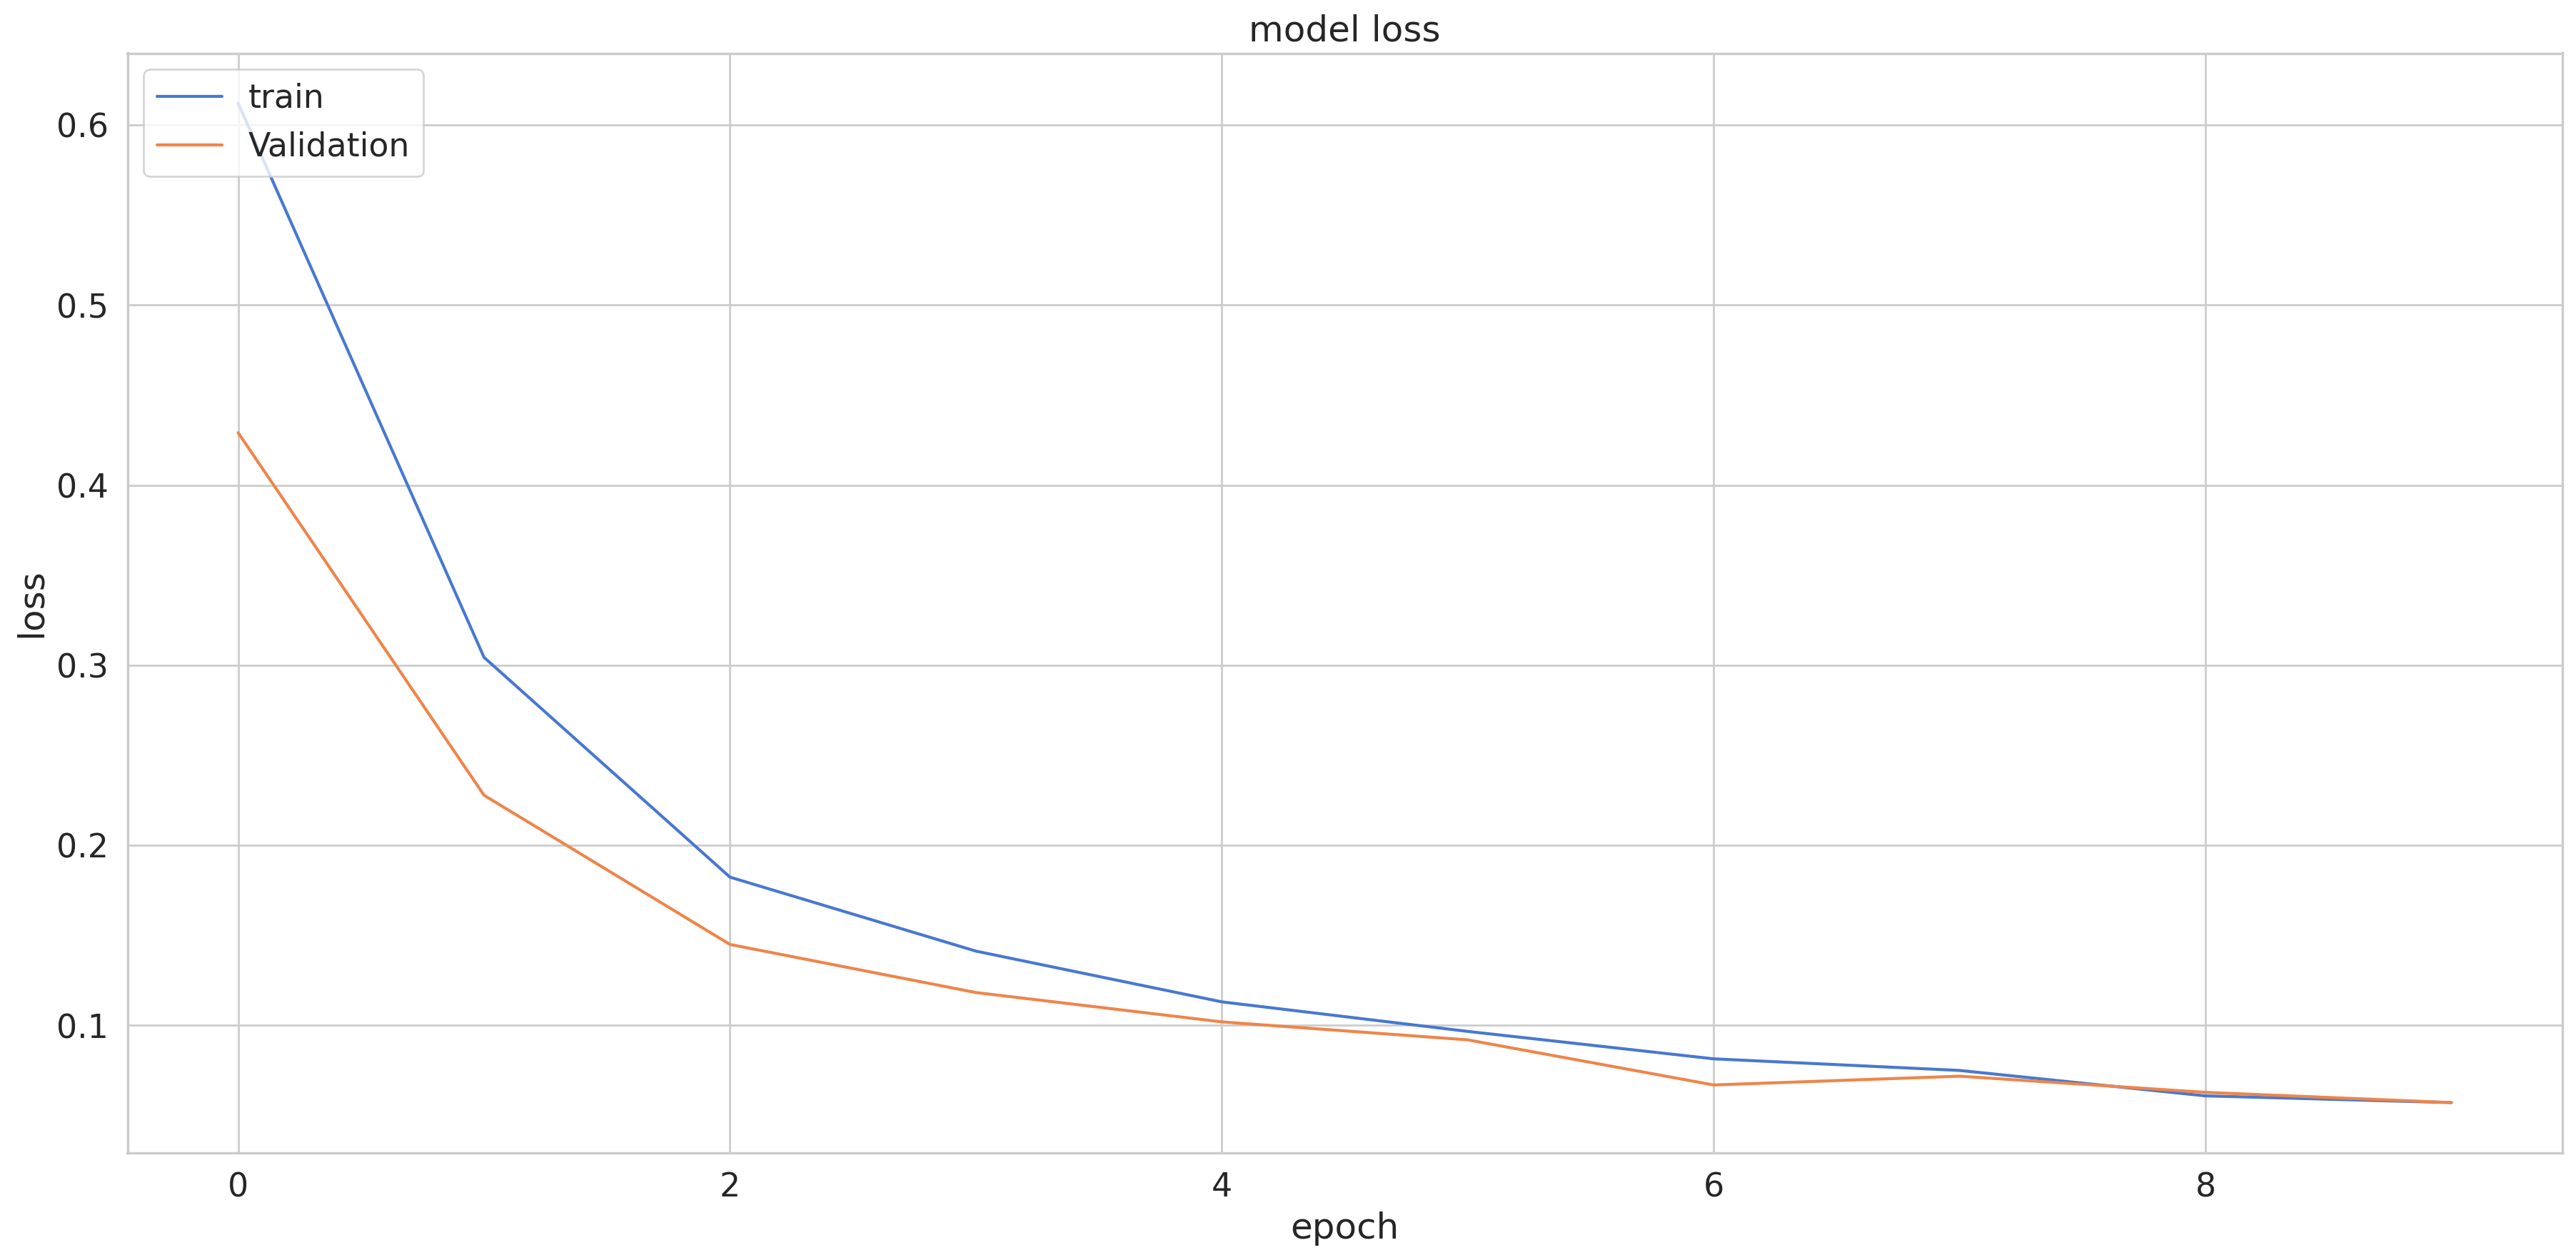

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

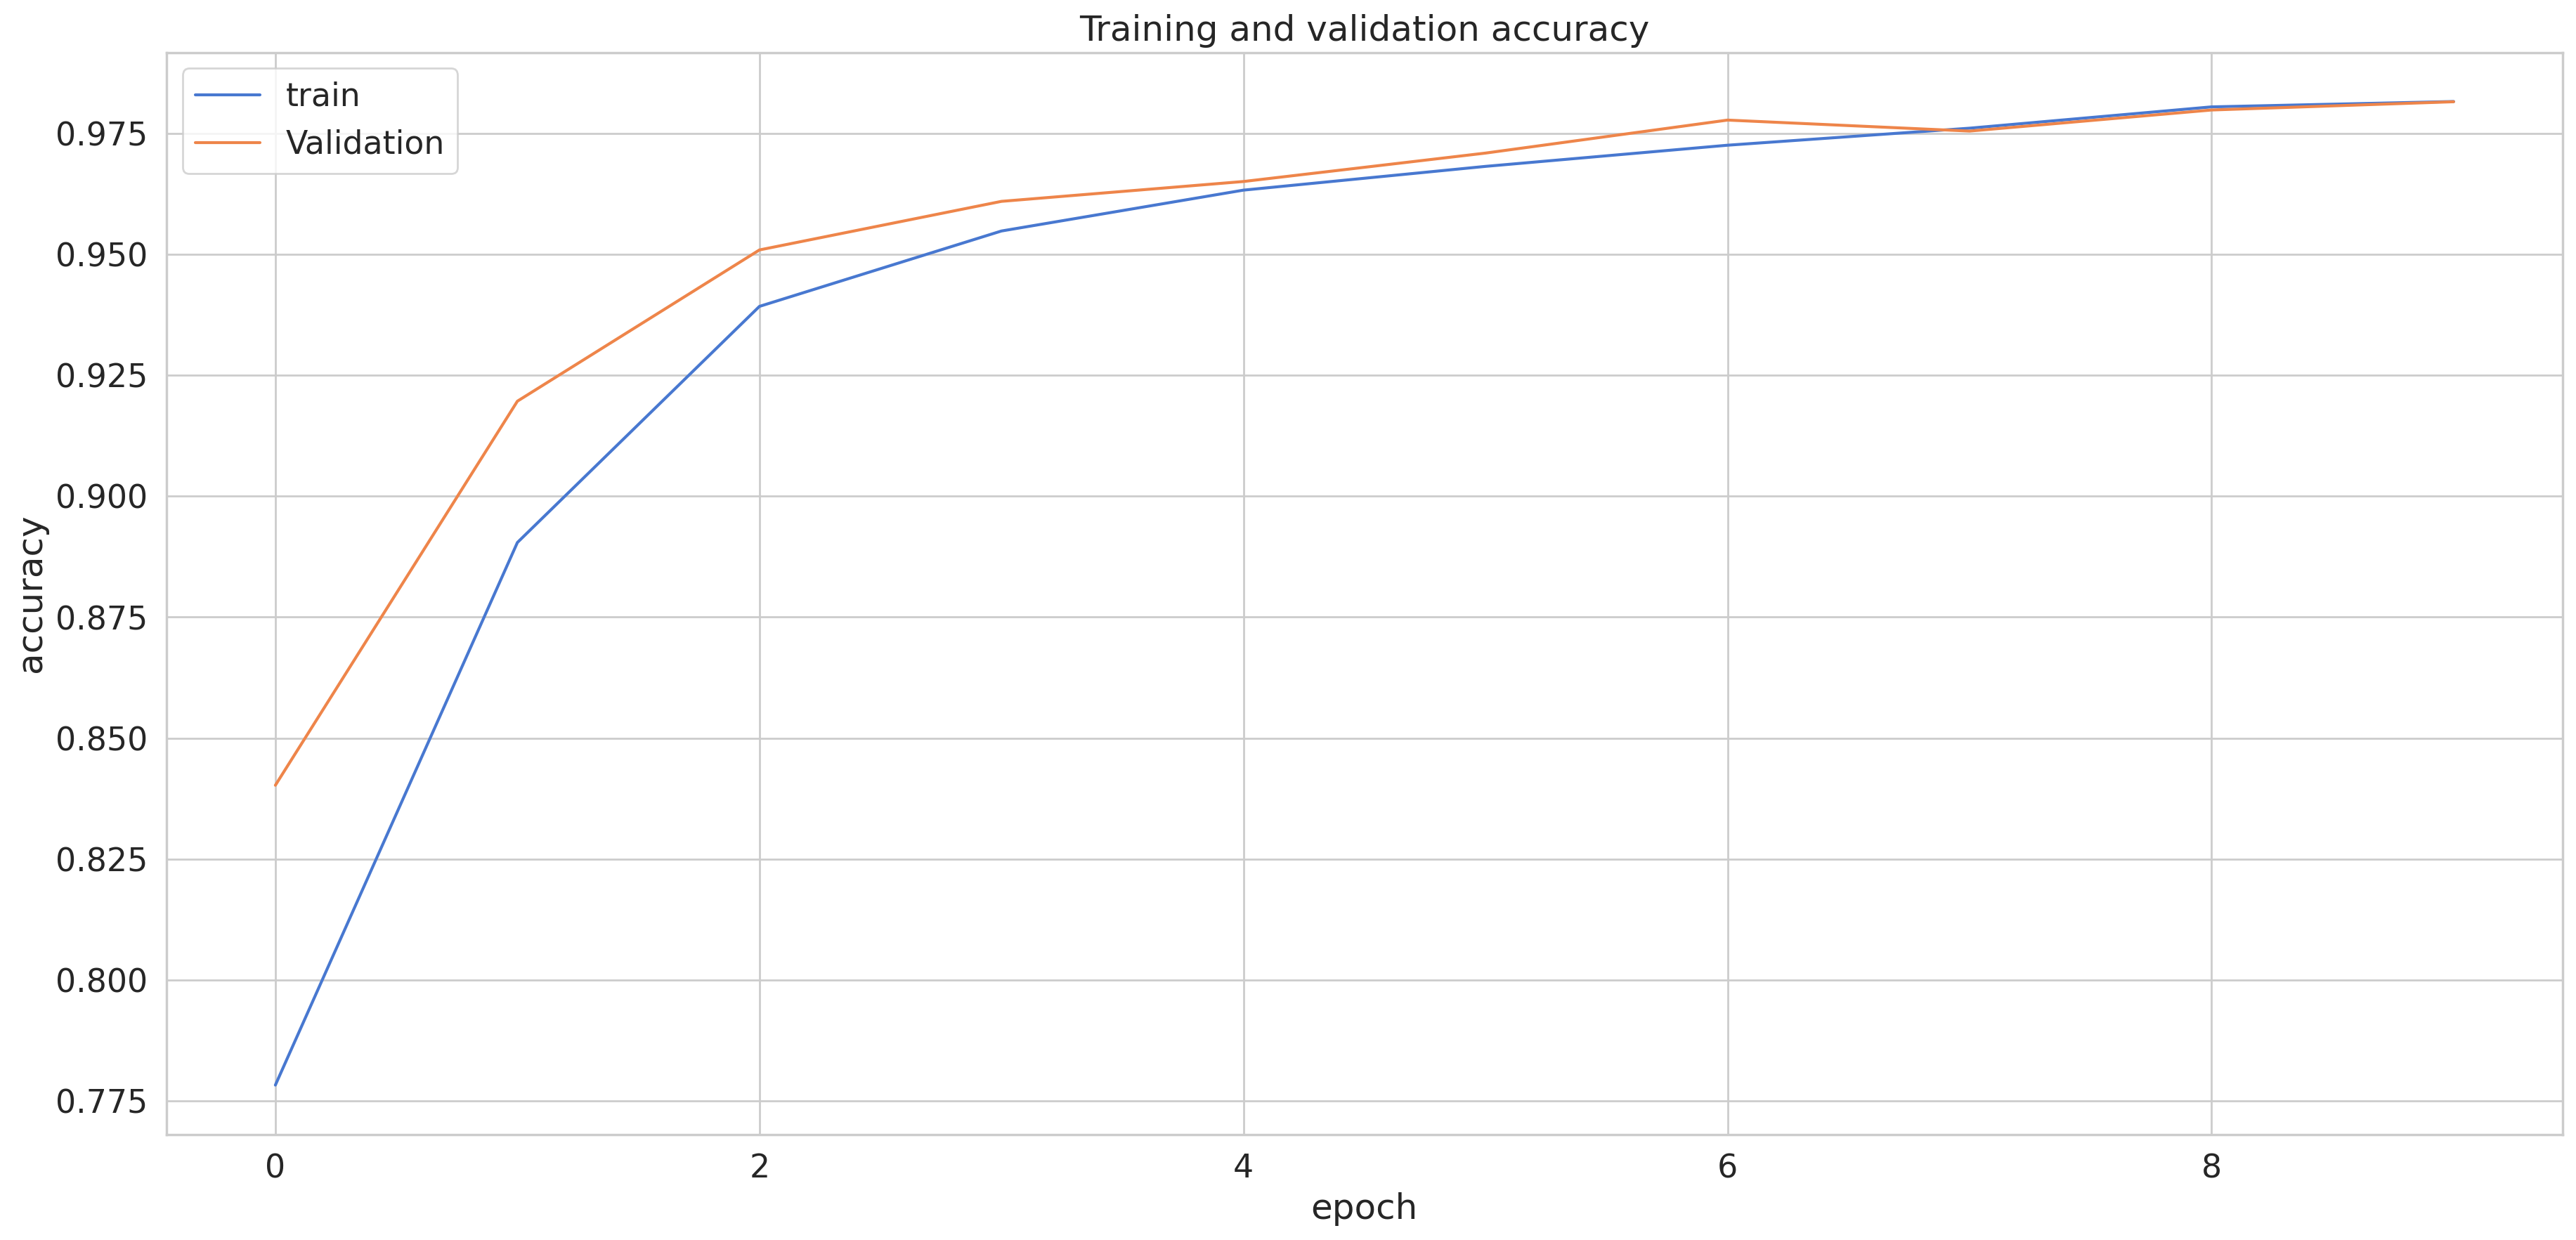

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

619/619 [==============================] - 56s 88ms/step
f1_score =  0.9828444888111499
0.9827246552507956
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      8490
           1       1.00      0.99      0.99      6843
           2       0.96      0.95      0.95      2459
           3       0.92      0.97      0.94      2005

    accuracy                           0.98     19797
   macro avg       0.97      0.98      0.97     19797
weighted avg       0.98      0.98      0.98     19797



<Axes: >

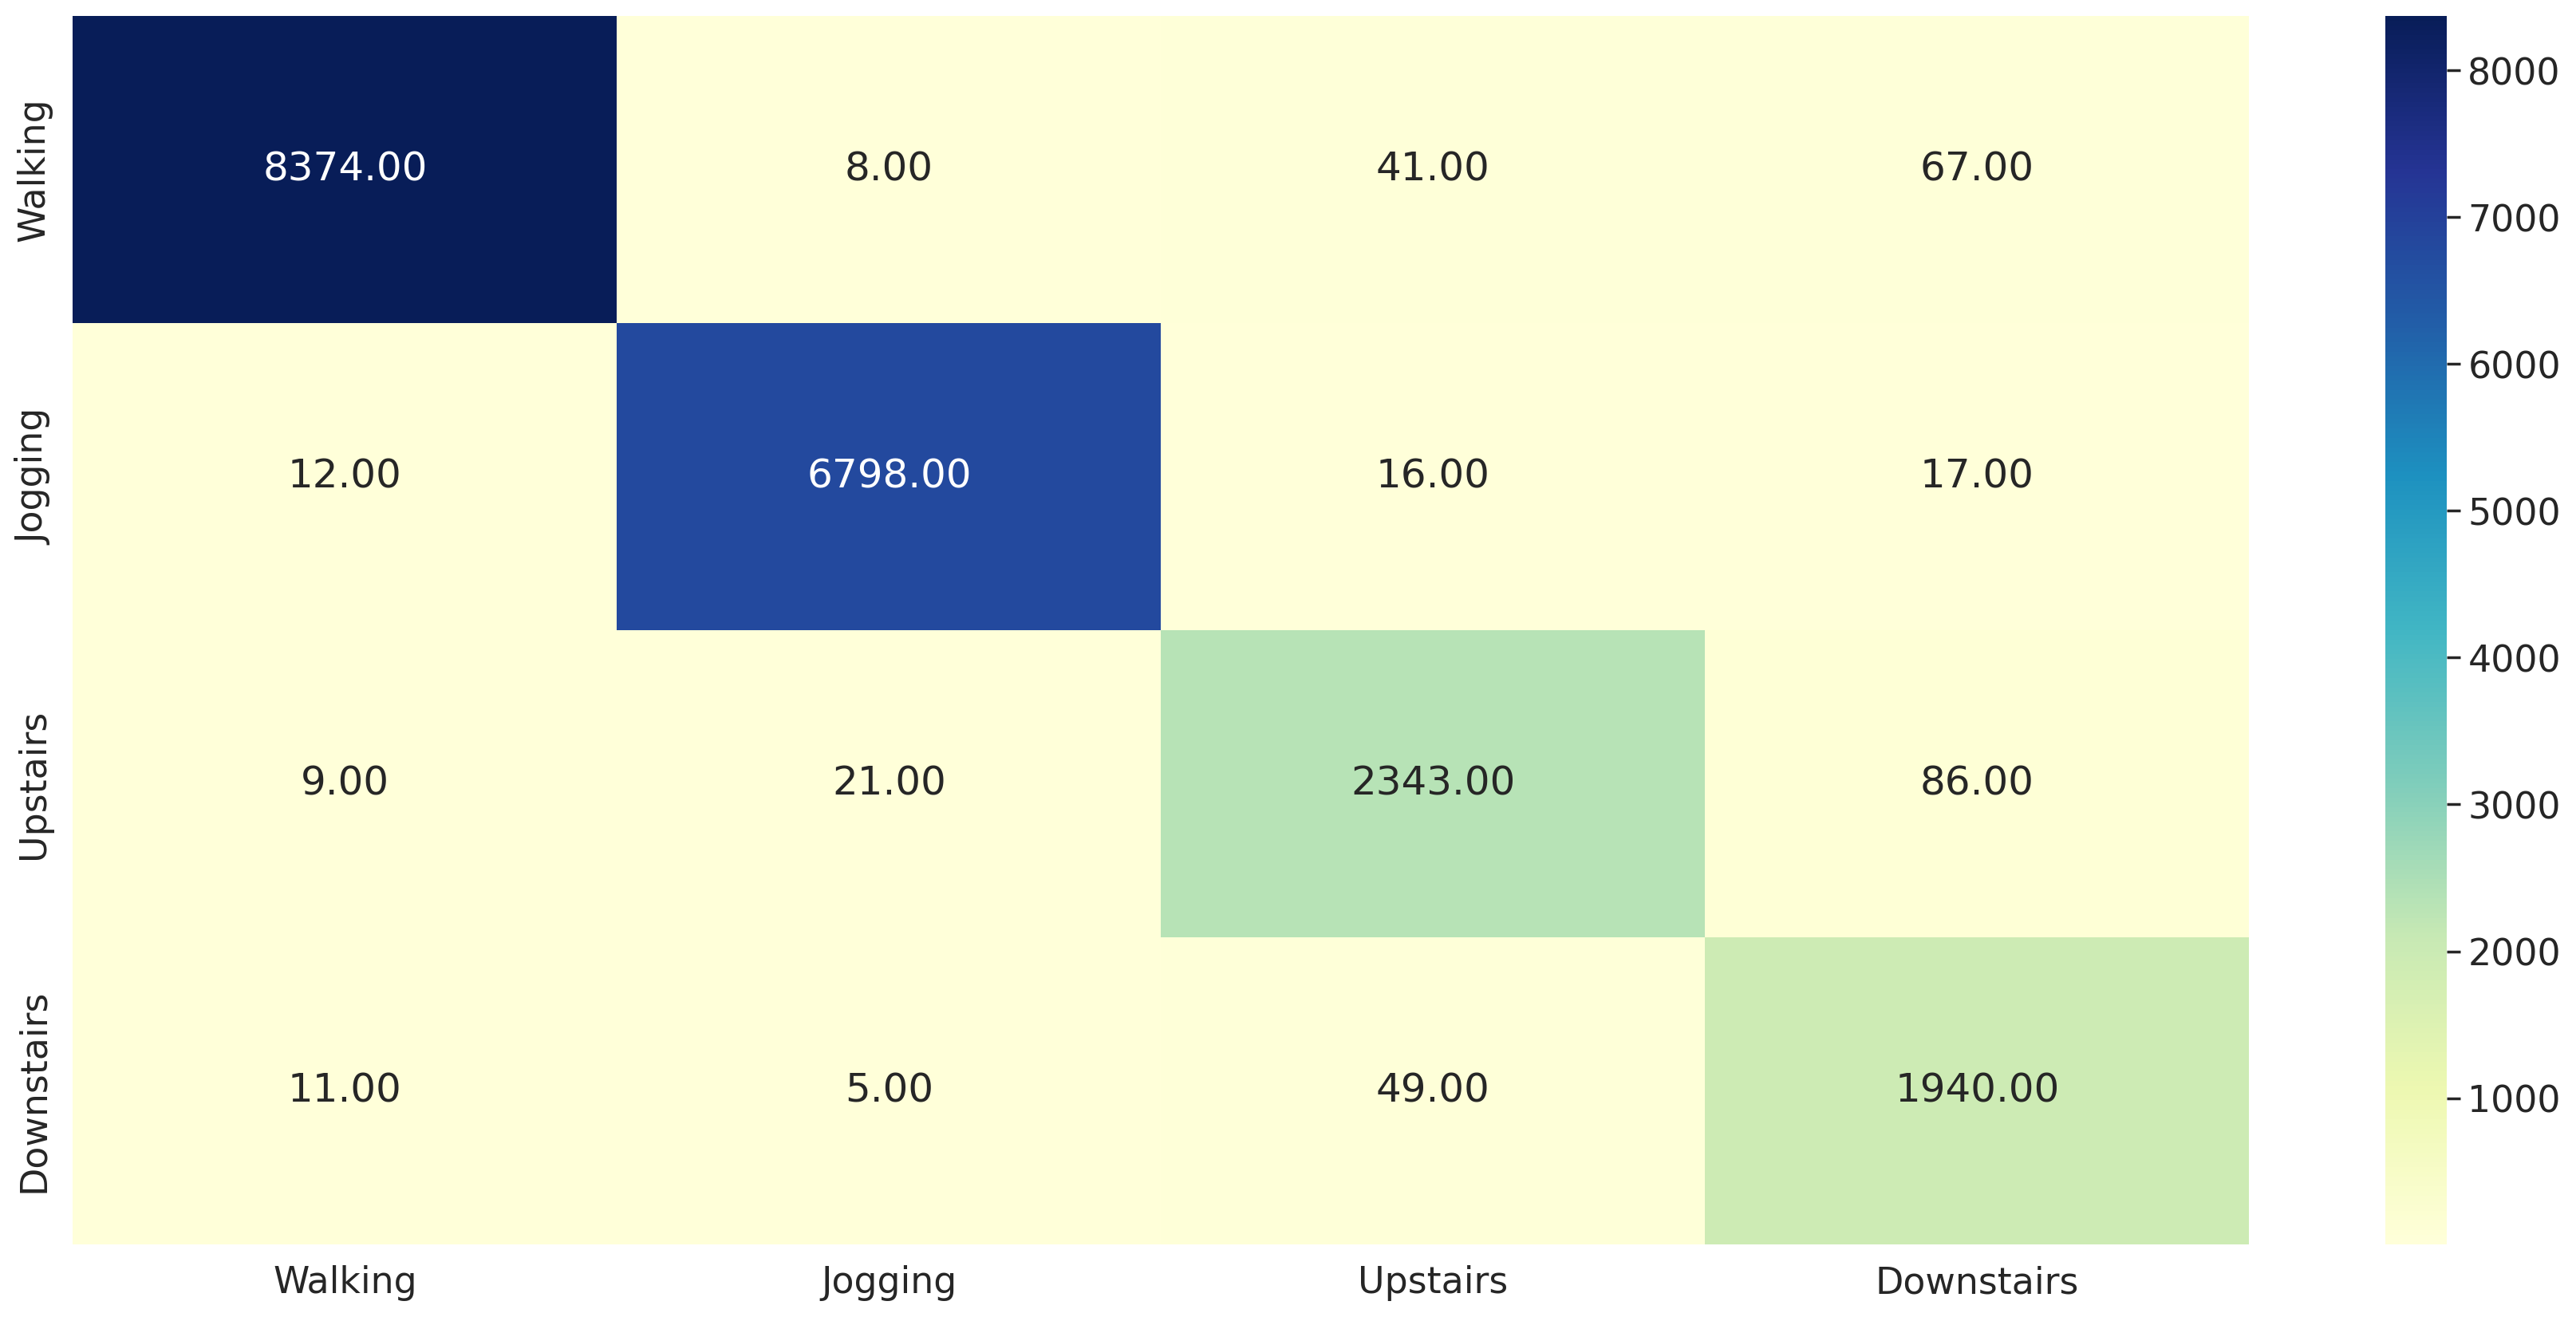

In [ ]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

y_pred=model.predict(X_test)
y_pred = np.argmax(y_pred, axis=-1)
y_true = np.argmax(y_test_hot, axis=-1)

LABELS = ['Walking', 'Jogging', 'Upstairs', 'Downstairs']
cm=confusion_matrix(y_true,y_pred)

#print(cm)
print('f1_score = ', f1_score(y_test, y_pred, average='weighted'))
print(accuracy_score(y_true,y_pred))
print(classification_report(y_true,y_pred))
sns.heatmap(cm, cmap="YlGnBu", xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt = '.2f')

# LSTM4

In [ ]:
model = Sequential()
# RNN layer
model.add(LSTM(units = 128, return_sequences=True, input_shape = (X_train.shape[1], X_train.shape[2])))
# Dropout layer
model.add(Dropout(0.5))

model.add(LSTM(128,return_sequences=True))
model.add(Dropout(0.5))

model.add(LSTM(128,return_sequences=True))
model.add(Dropout(0.5))

model.add(LSTM(128))
model.add(Dropout(0.5))
# Dense layer with ReLu
model.add(Dense(units = 64, activation='relu'))
# Softmax layer
model.add(Dense(y_train_hot.shape[1], activation = 'softmax'))
# Compile model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 50, 128)           67584     
                                                                 
 dropout_6 (Dropout)         (None, 50, 128)           0         
                                                                 
 lstm_7 (LSTM)               (None, 50, 128)           131584    
                                                                 
 dropout_7 (Dropout)         (None, 50, 128)           0         
                                                                 
 lstm_8 (LSTM)               (None, 50, 128)           131584    
                                                                 
 dropout_8 (Dropout)         (None, 50, 128)           0         
                                                                 
 lstm_9 (LSTM)               (None, 128)              

In [ ]:
# validation_split = 0.1
batch_size = 128

train_epochs = 10
history = model.fit(X_train, y_train_hot, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_data = (X_val, y_val_hot), shuffle=True)


Epoch 1/10
495/495 [==============================] - 383s 755ms/step - loss: 0.6335 - accuracy: 0.7719 - val_loss: 0.4142 - val_accuracy: 0.8524
Epoch 2/10
495/495 [==============================] - 380s 768ms/step - loss: 0.3087 - accuracy: 0.8941 - val_loss: 0.1944 - val_accuracy: 0.9356
Epoch 3/10
495/495 [==============================] - 382s 773ms/step - loss: 0.1889 - accuracy: 0.9381 - val_loss: 0.1638 - val_accuracy: 0.9482
Epoch 4/10
495/495 [==============================] - 386s 780ms/step - loss: 0.1435 - accuracy: 0.9544 - val_loss: 0.1144 - val_accuracy: 0.9639
Epoch 5/10
495/495 [==============================] - 388s 783ms/step - loss: 0.1098 - accuracy: 0.9647 - val_loss: 0.0959 - val_accuracy: 0.9684
Epoch 6/10
495/495 [==============================] - 388s 785ms/step - loss: 0.0951 - accuracy: 0.9696 - val_loss: 0.0817 - val_accuracy: 0.9723
Epoch 7/10
495/495 [==============================] - 386s 780ms/step - loss: 0.0789 - accuracy: 0.9748 - val_loss: 0.0827 -

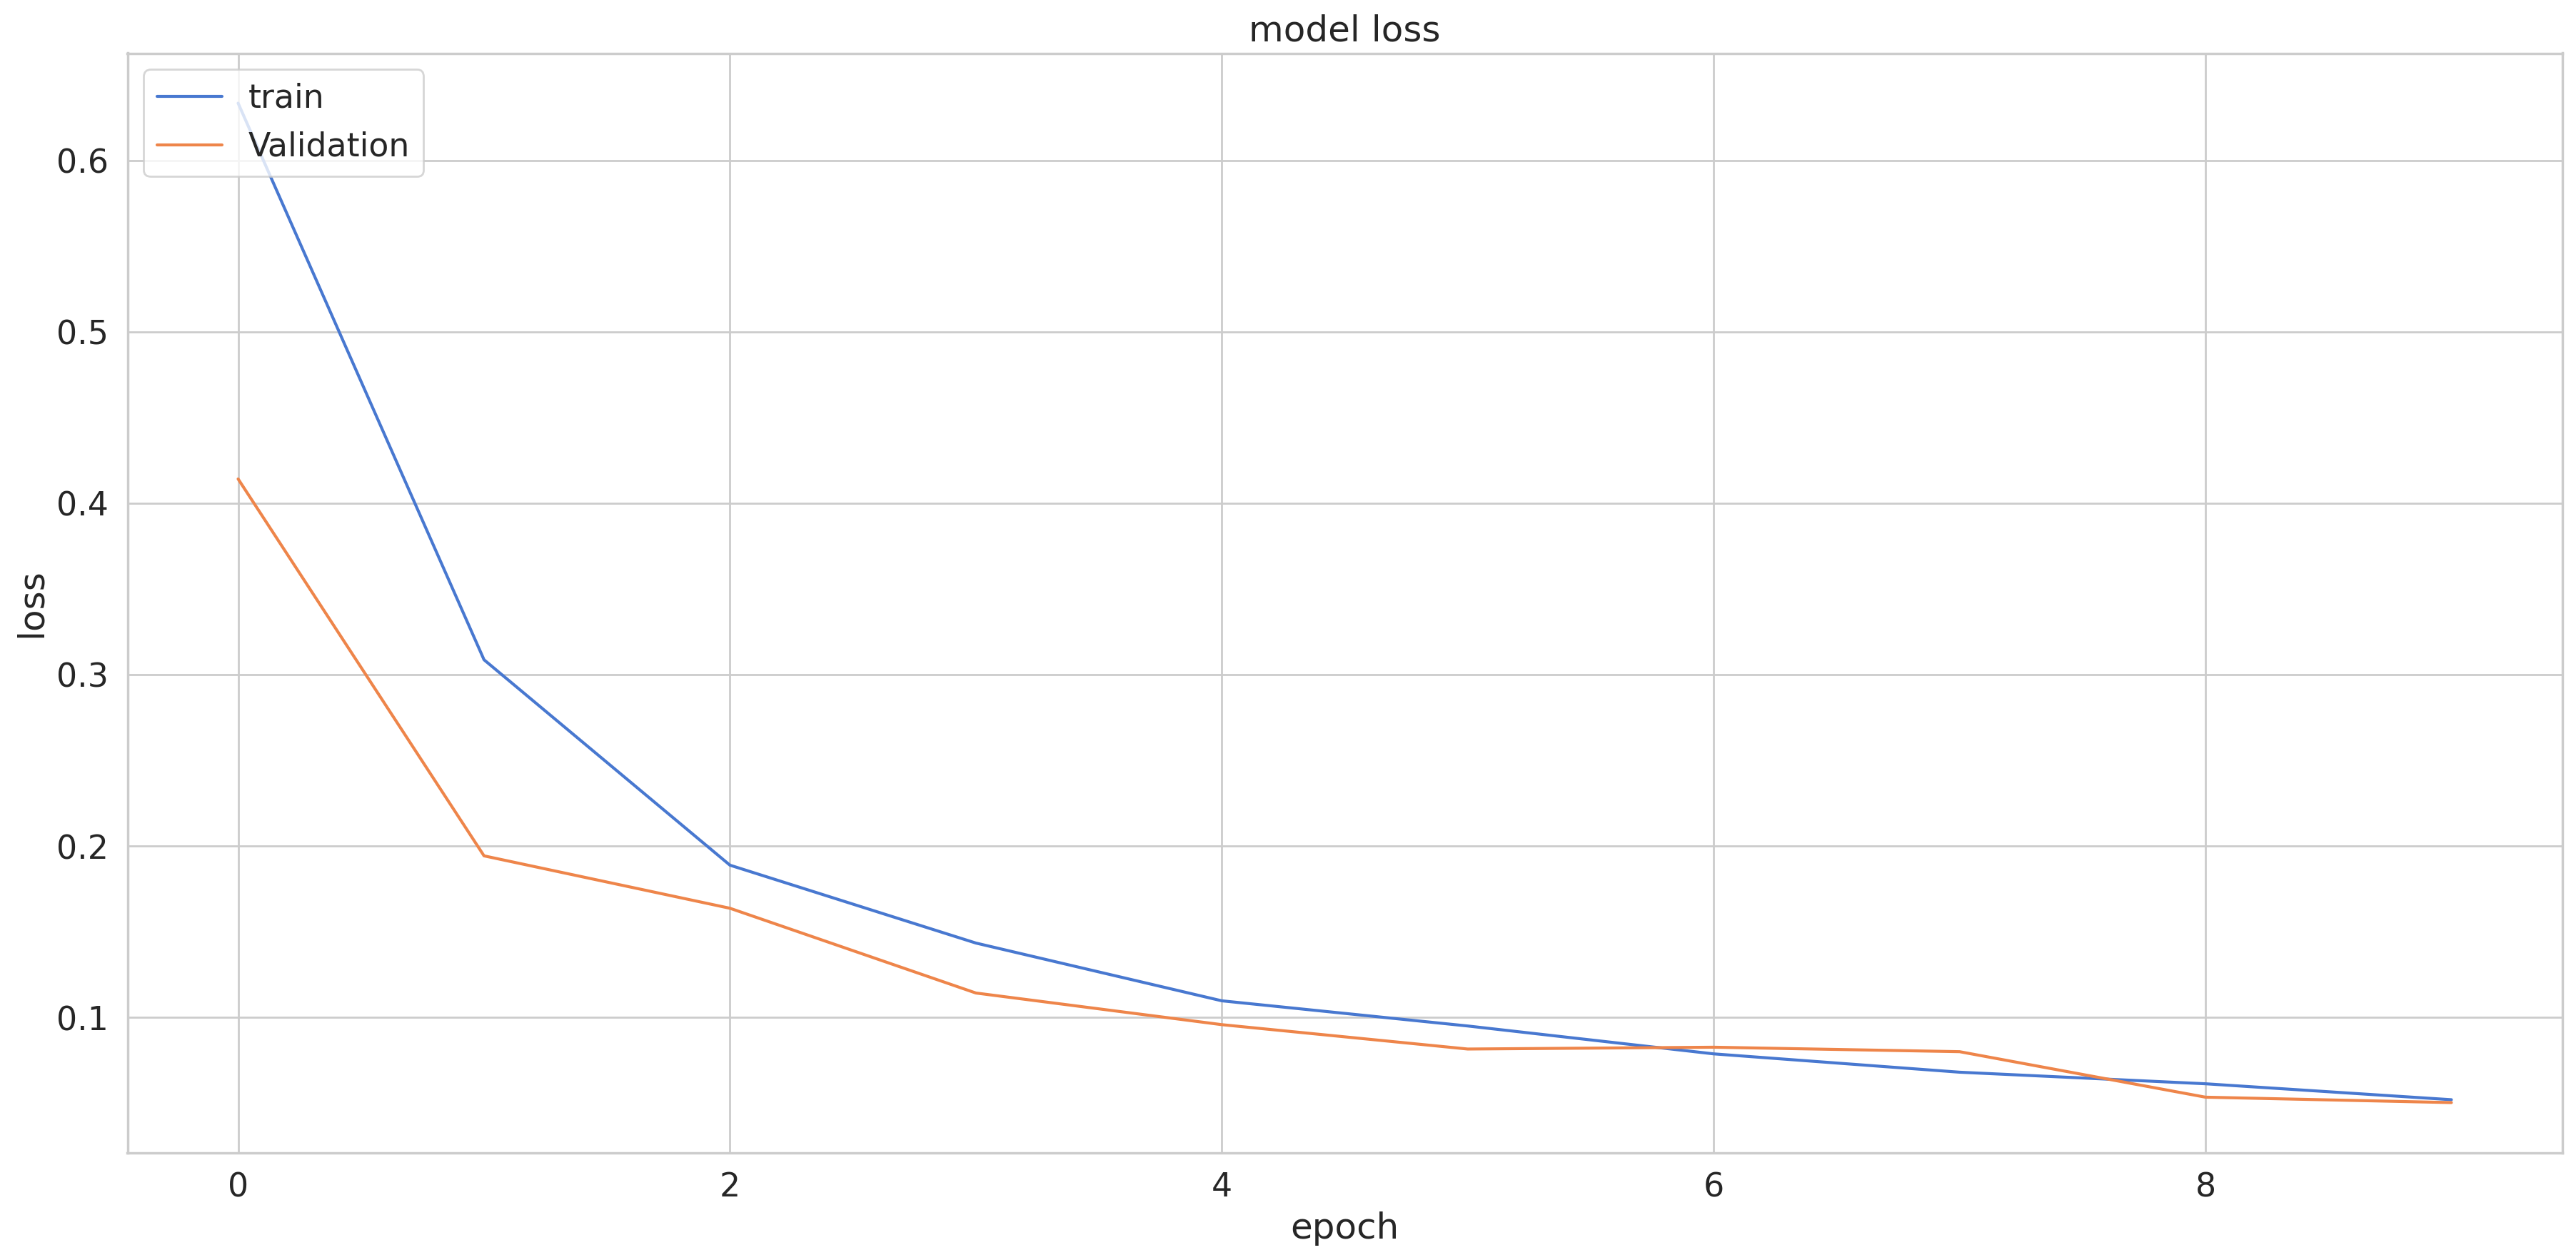

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

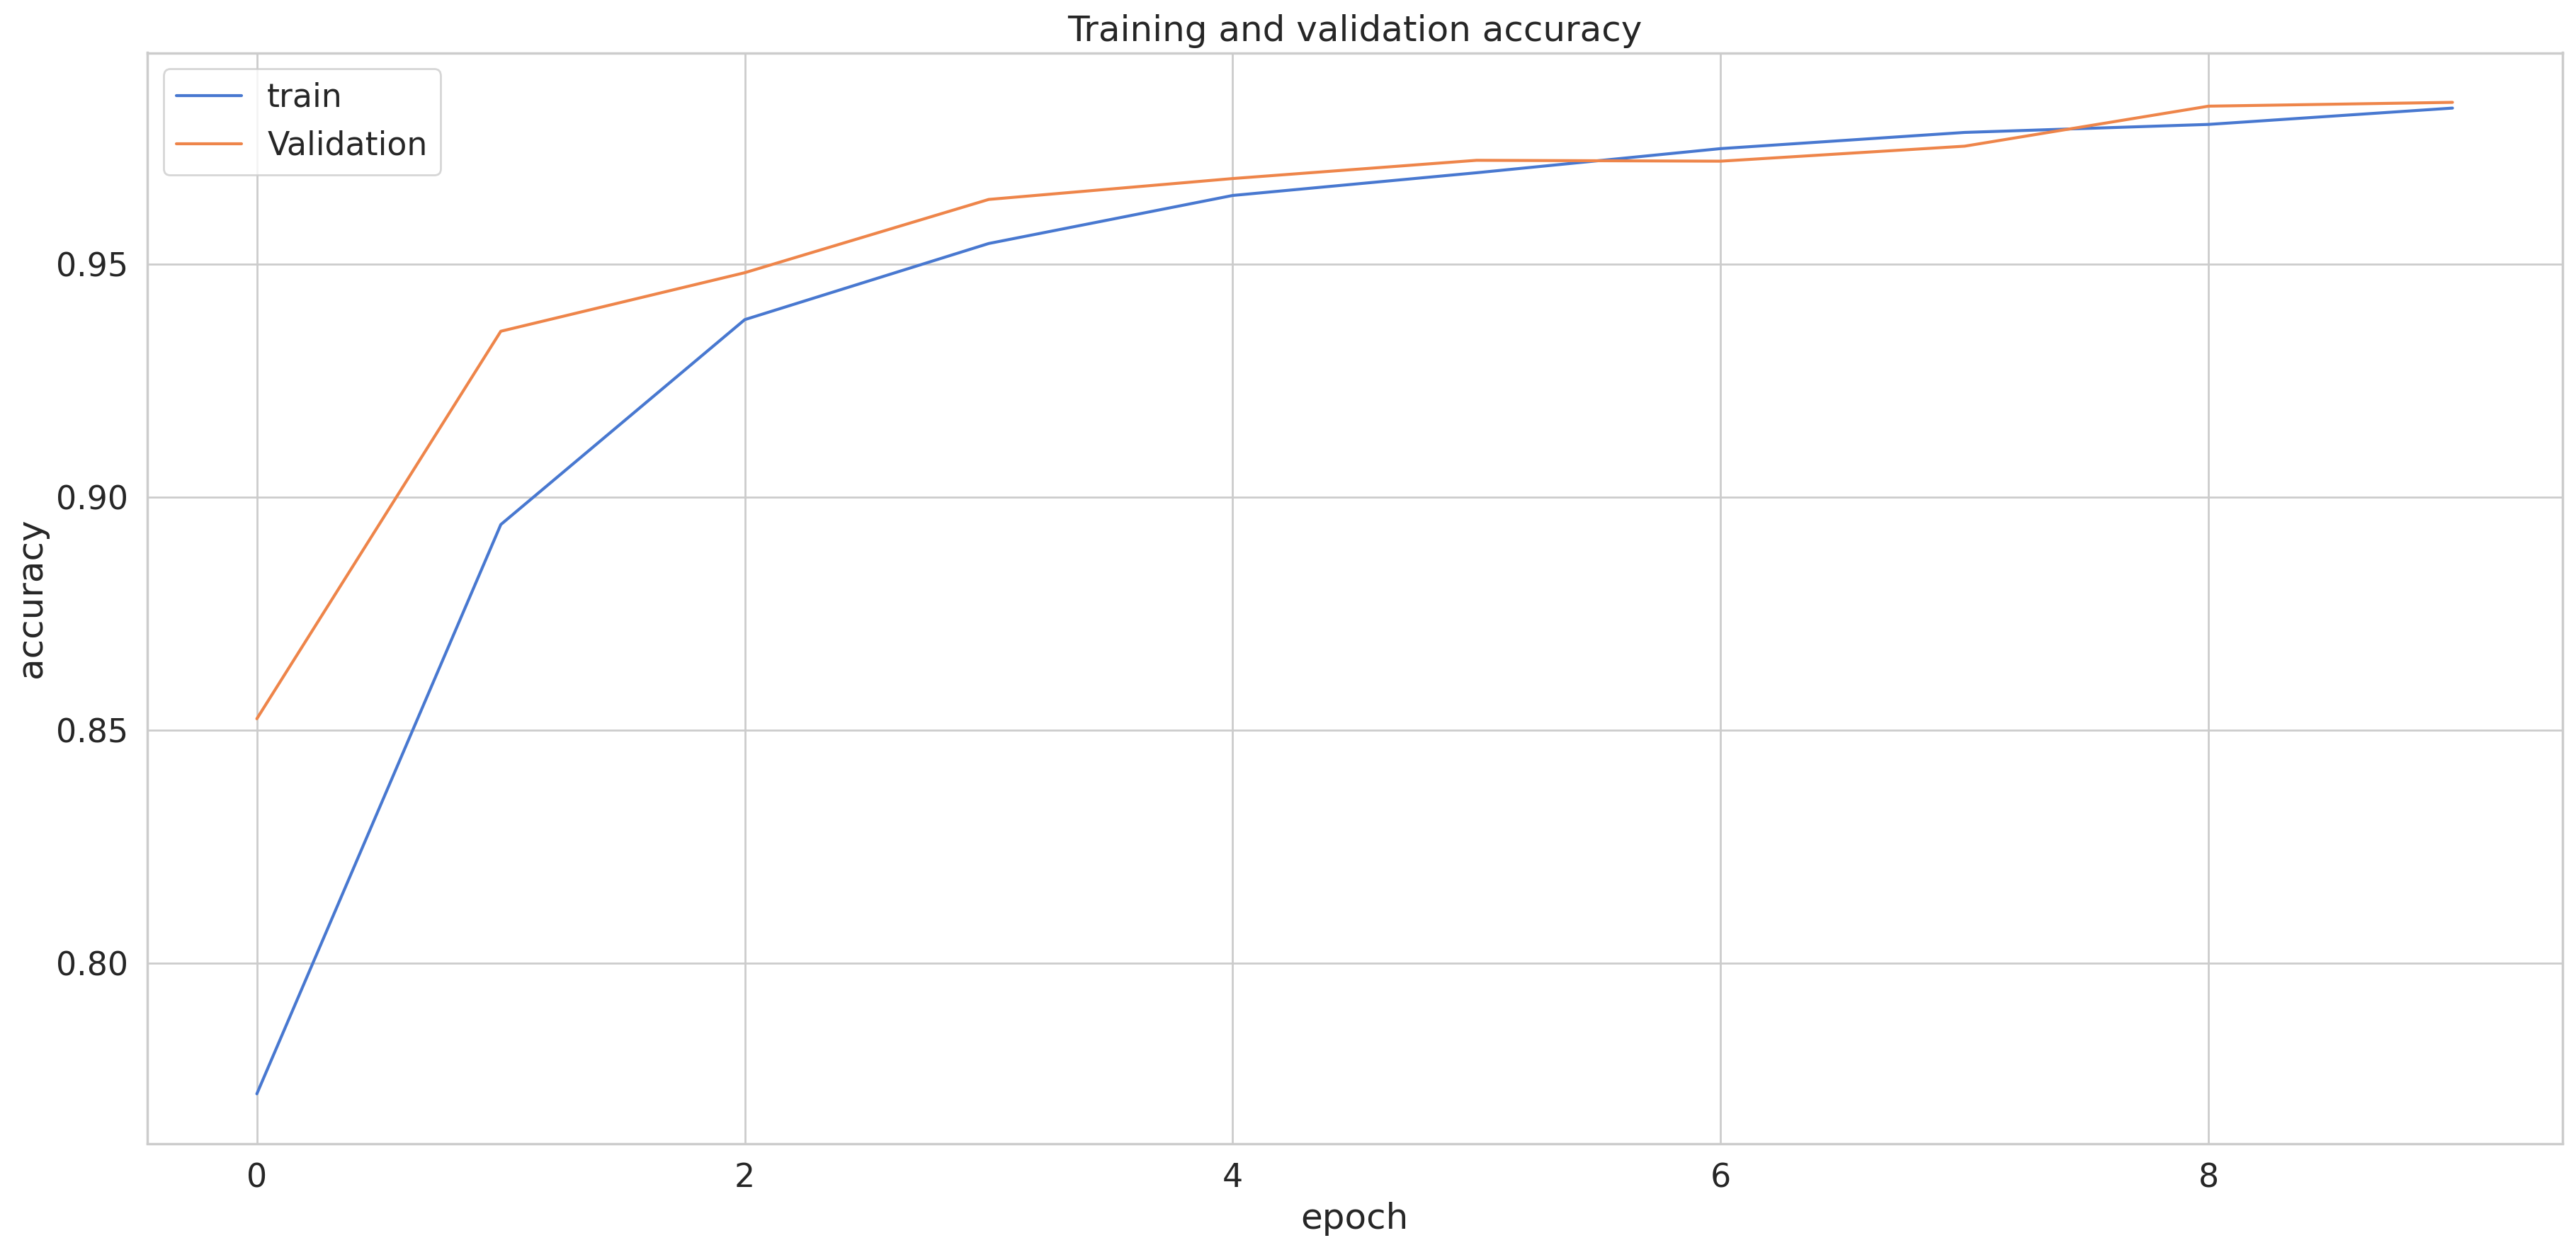

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

619/619 [==============================] - 77s 123ms/step
f1_score =  0.9864576871541648
0.9864120826387837
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      8490
           1       1.00      0.99      1.00      6843
           2       0.95      0.97      0.96      2459
           3       0.96      0.96      0.96      2005

    accuracy                           0.99     19797
   macro avg       0.98      0.98      0.98     19797
weighted avg       0.99      0.99      0.99     19797



<Axes: >

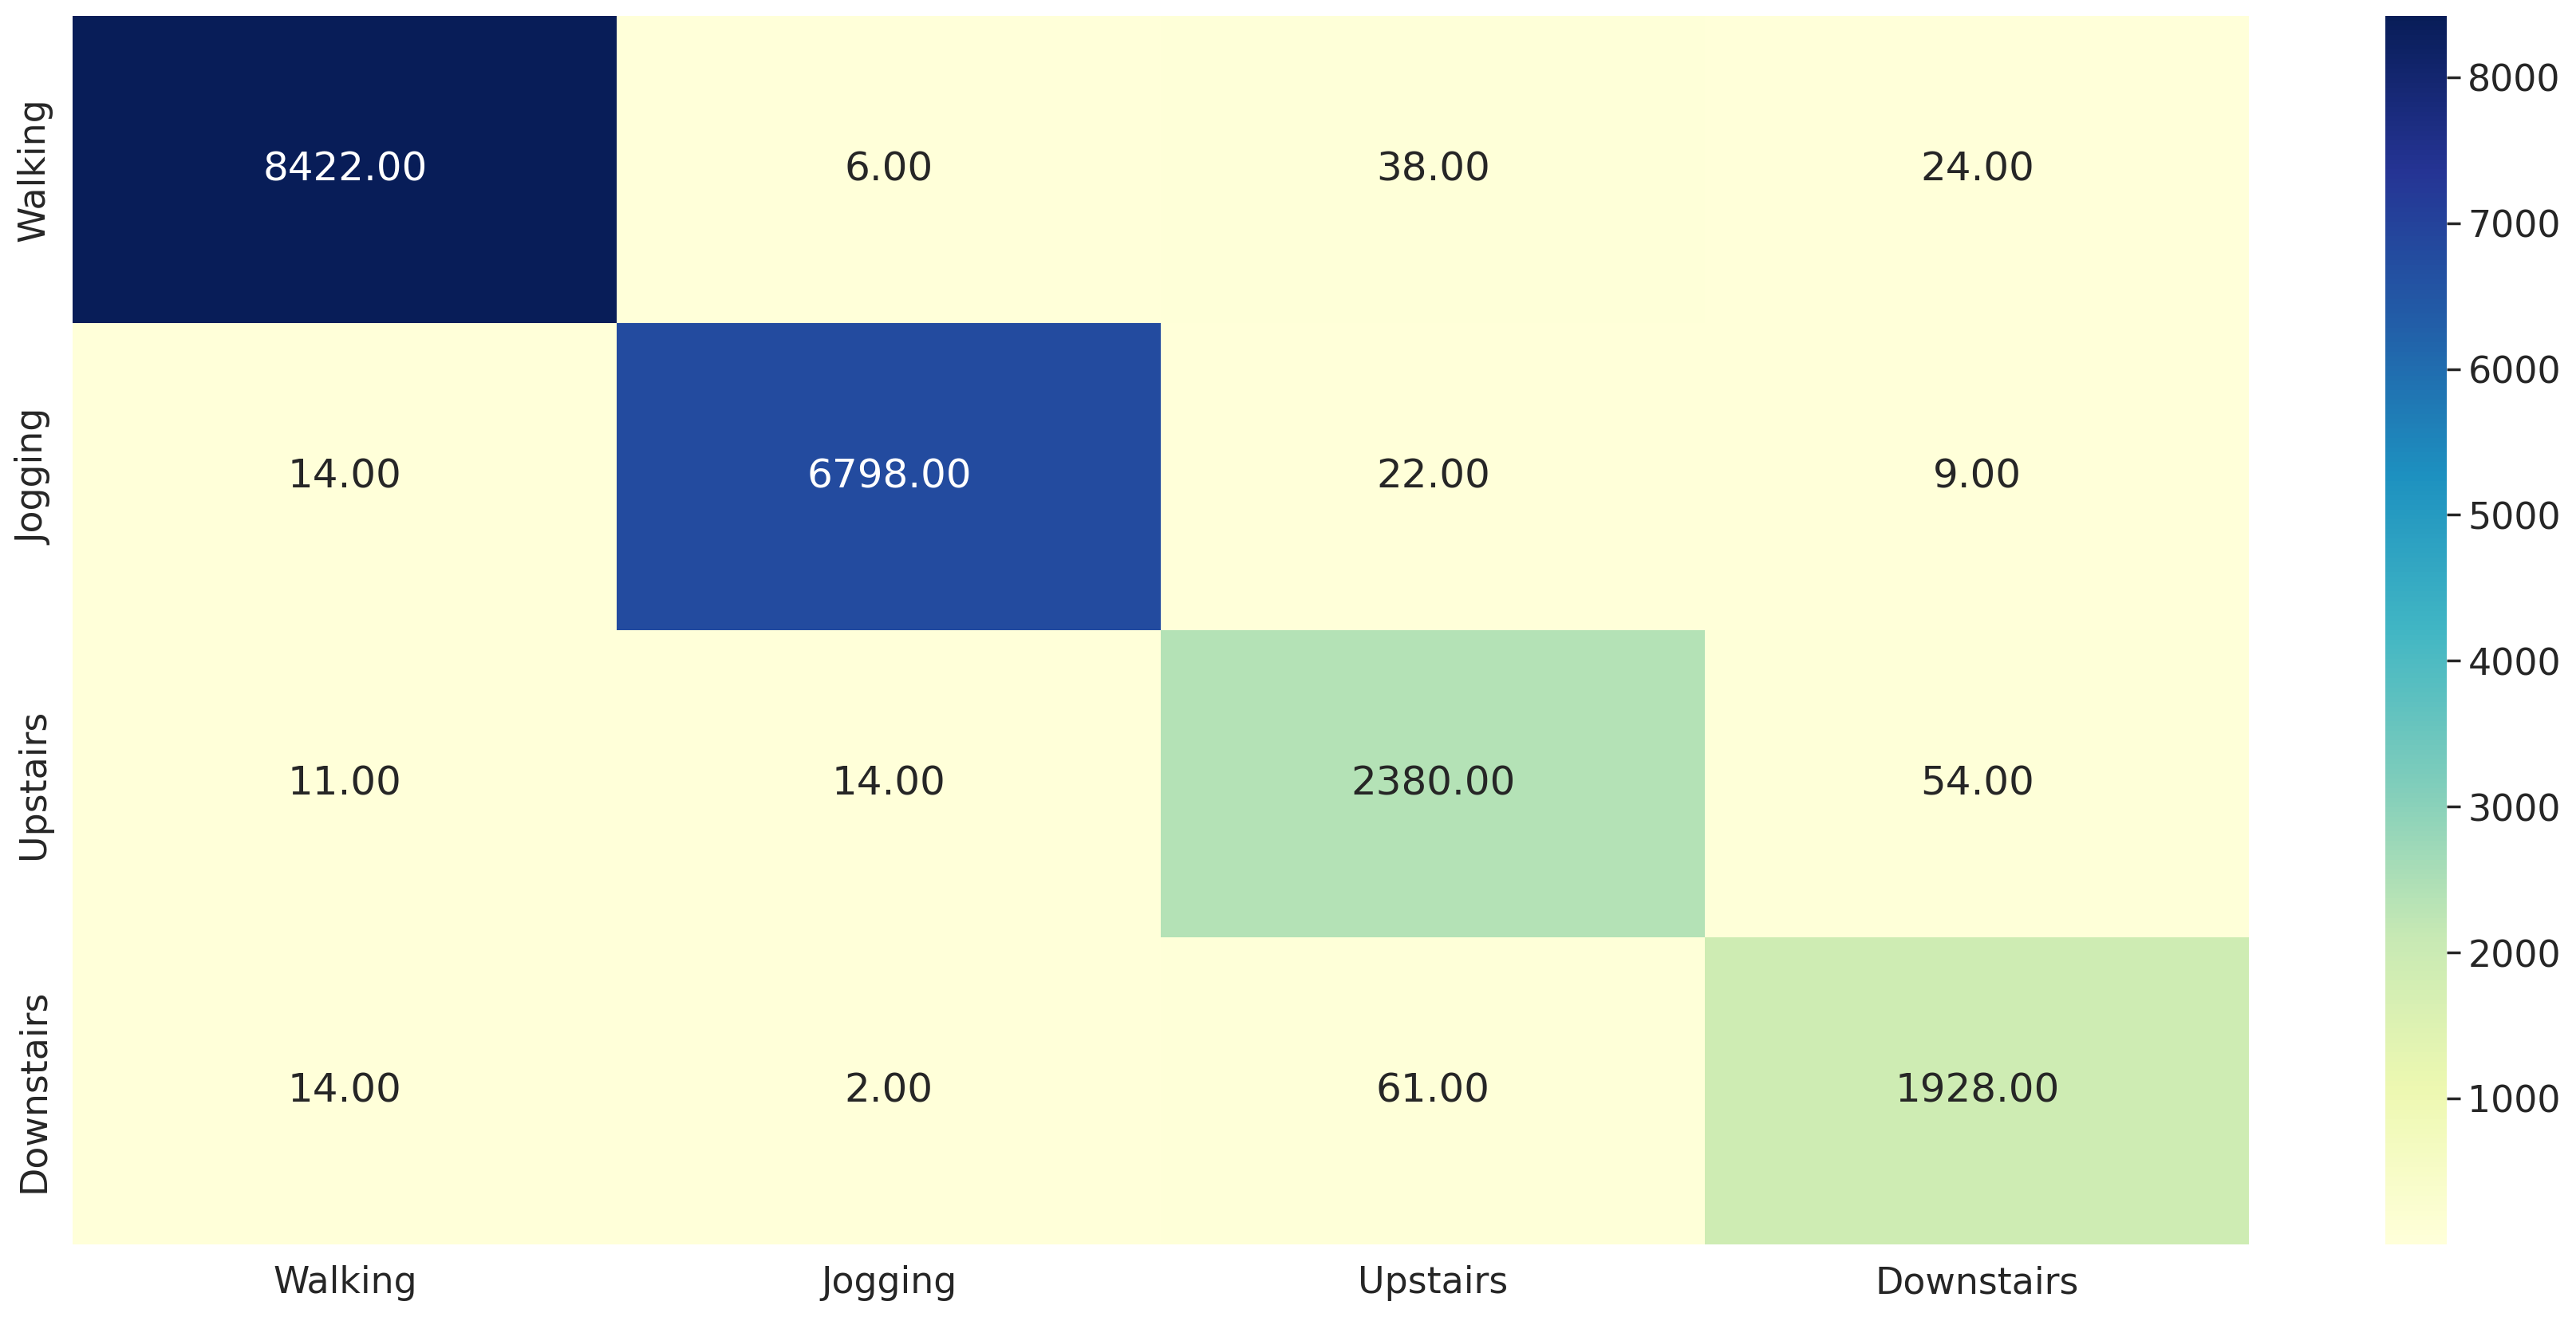

In [ ]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

y_pred=model.predict(X_test)
y_pred = np.argmax(y_pred, axis=-1)
y_true = np.argmax(y_test_hot, axis=-1)

LABELS = ['Walking', 'Jogging', 'Upstairs', 'Downstairs']
cm=confusion_matrix(y_true,y_pred)

#print(cm)
print('f1_score = ', f1_score(y_test, y_pred, average='weighted'))
print(accuracy_score(y_true,y_pred))
print(classification_report(y_true,y_pred))
sns.heatmap(cm, cmap="YlGnBu", xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt = '.2f')

# LSTM5

In [15]:
model = Sequential()
# RNN layer
model.add(LSTM(units = 128, return_sequences=True, input_shape = (X_train.shape[1], X_train.shape[2])))
# Dropout layer
model.add(Dropout(0.5))

model.add(LSTM(128,return_sequences=True))
model.add(Dropout(0.5))

model.add(LSTM(128,return_sequences=True))
model.add(Dropout(0.5))


model.add(LSTM(128,return_sequences=True))
model.add(Dropout(0.5))

model.add(LSTM(128))
model.add(Dropout(0.5))
# Dense layer with ReLu
model.add(Dense(units = 64, activation='relu'))
# Softmax layer
model.add(Dense(y_train_hot.shape[1], activation = 'softmax'))
# Compile model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 50, 128)           67584     
                                                                 
 dropout (Dropout)           (None, 50, 128)           0         
                                                                 
 lstm_1 (LSTM)               (None, 50, 128)           131584    
                                                                 
 dropout_1 (Dropout)         (None, 50, 128)           0         
                                                                 
 lstm_2 (LSTM)               (None, 50, 128)           131584    
                                                                 
 dropout_2 (Dropout)         (None, 50, 128)           0         
                                                                 
 lstm_3 (LSTM)               (None, 50, 128)           1

In [16]:
# validation_split = 0.1
batch_size = 128

train_epochs = 10
history = model.fit(X_train, y_train_hot, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_data = (X_val, y_val_hot), shuffle=True)


Epoch 1/10
495/495 [==============================] - 565s 1s/step - loss: 0.6154 - accuracy: 0.7806 - val_loss: 0.4143 - val_accuracy: 0.8554
Epoch 2/10
495/495 [==============================] - 540s 1s/step - loss: 0.2886 - accuracy: 0.9008 - val_loss: 0.2397 - val_accuracy: 0.9255
Epoch 3/10
495/495 [==============================] - 500s 1s/step - loss: 0.1889 - accuracy: 0.9387 - val_loss: 0.1440 - val_accuracy: 0.9534
Epoch 4/10
495/495 [==============================] - 538s 1s/step - loss: 0.1386 - accuracy: 0.9569 - val_loss: 0.1075 - val_accuracy: 0.9639
Epoch 5/10
495/495 [==============================] - 495s 1s/step - loss: 0.1095 - accuracy: 0.9650 - val_loss: 0.0971 - val_accuracy: 0.9674
Epoch 6/10
495/495 [==============================] - 536s 1s/step - loss: 0.0951 - accuracy: 0.9701 - val_loss: 0.0781 - val_accuracy: 0.9759
Epoch 7/10
495/495 [==============================] - 493s 997ms/step - loss: 0.0828 - accuracy: 0.9736 - val_loss: 0.0652 - val_accuracy: 0.9

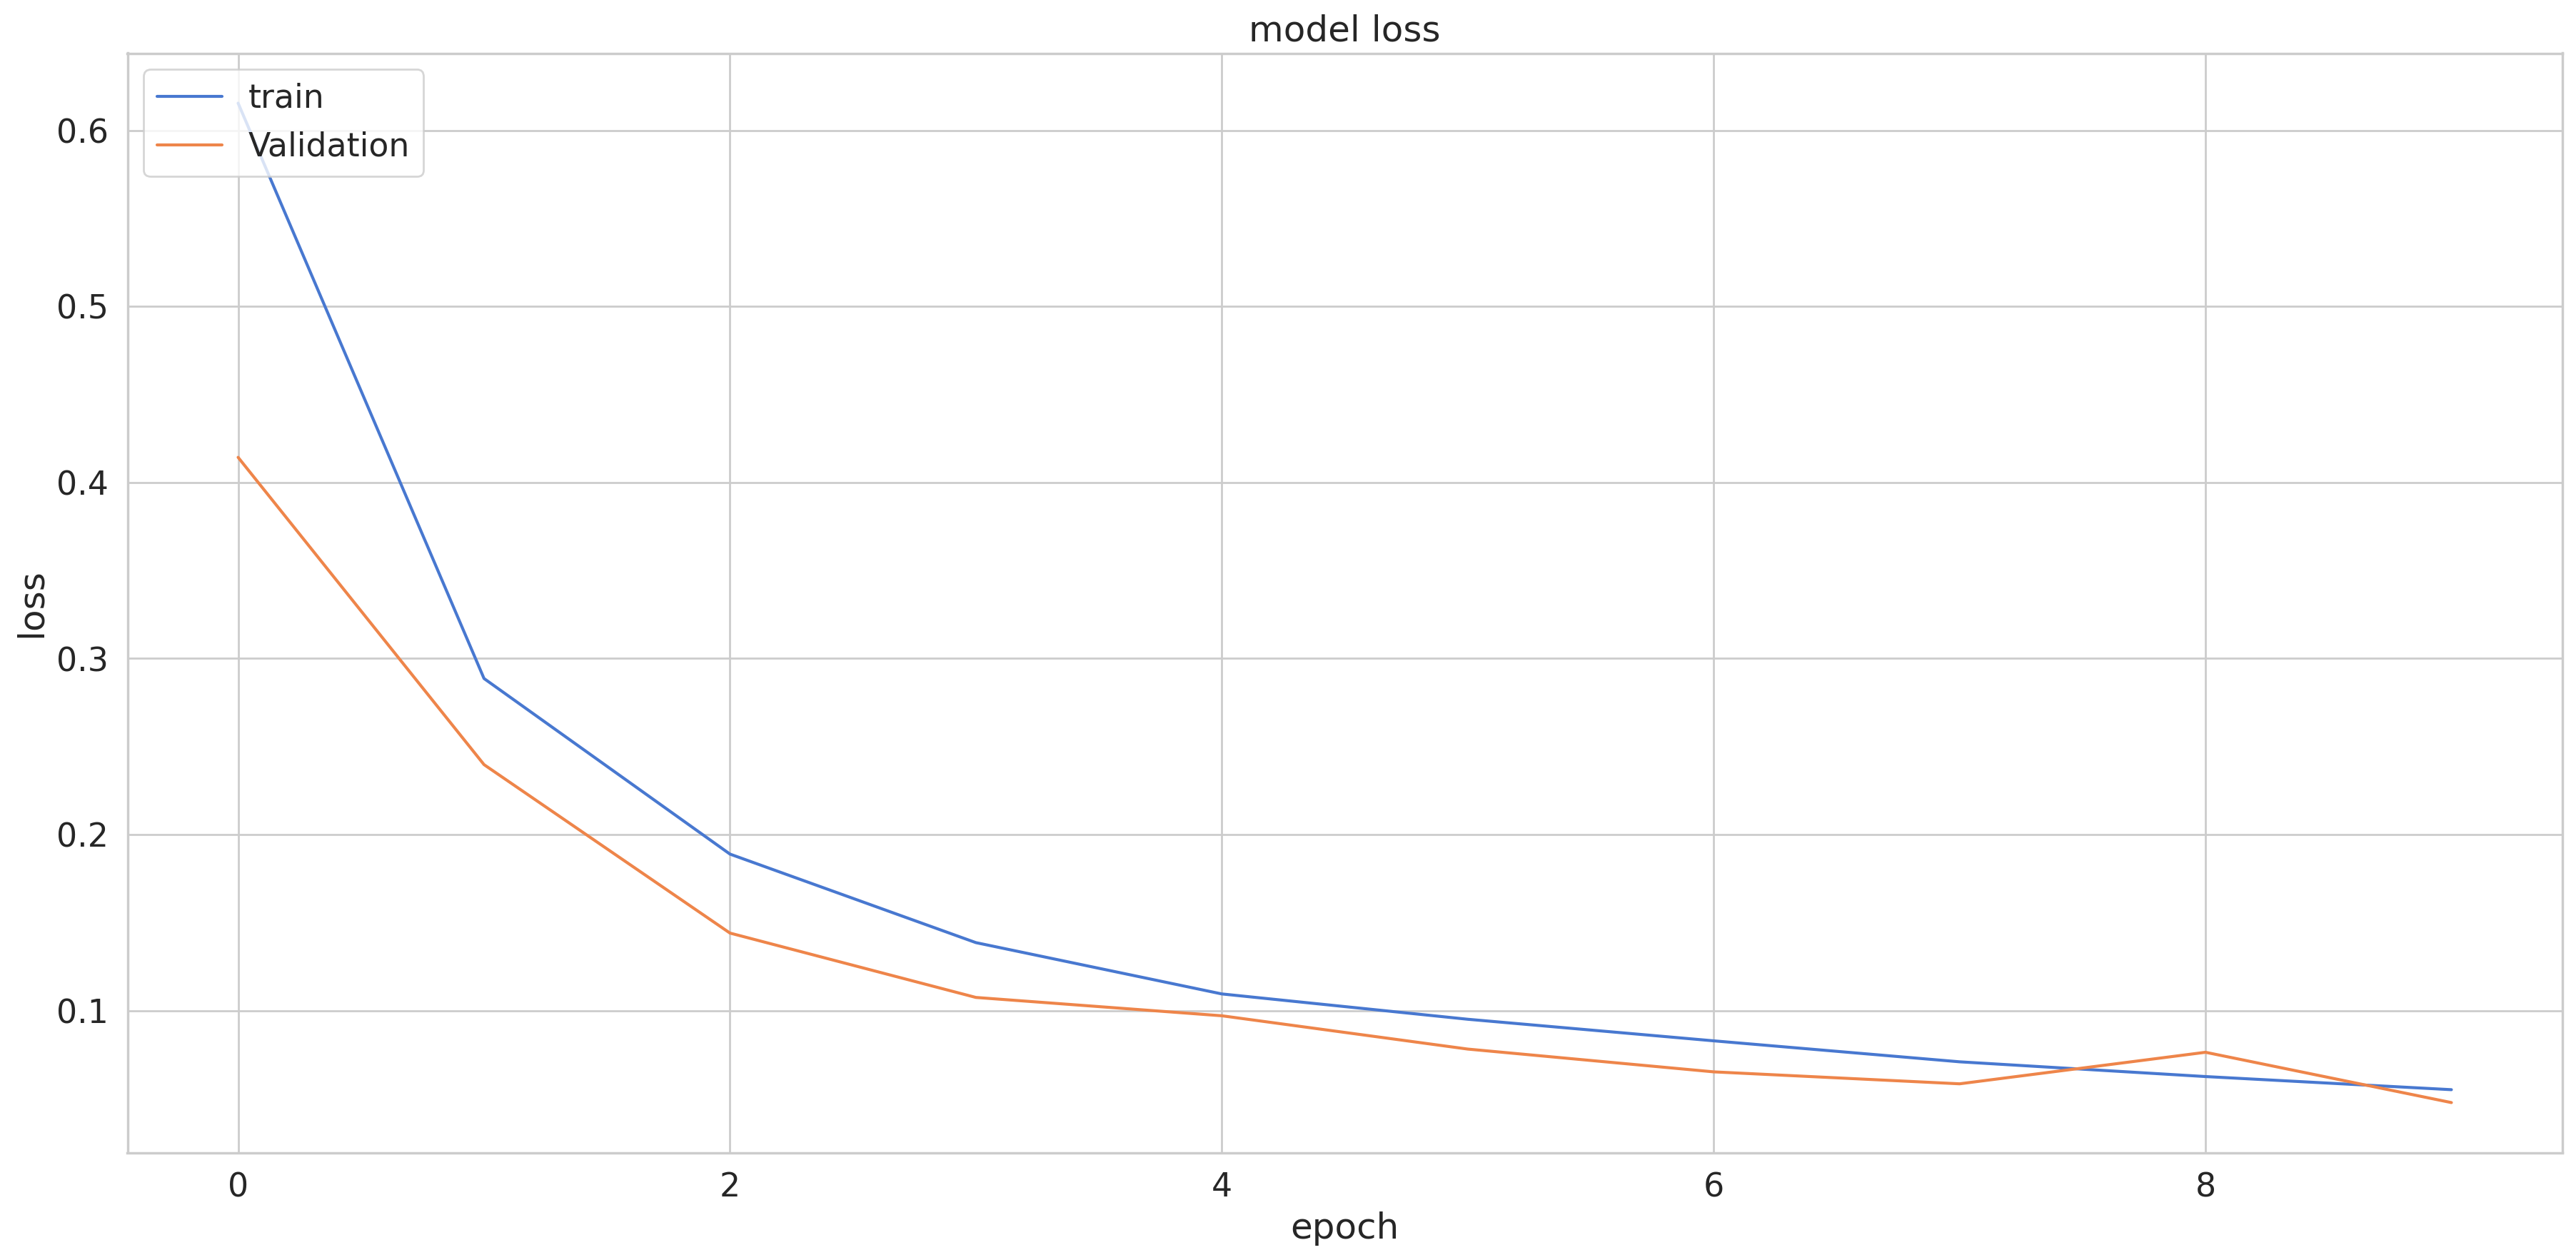

In [17]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

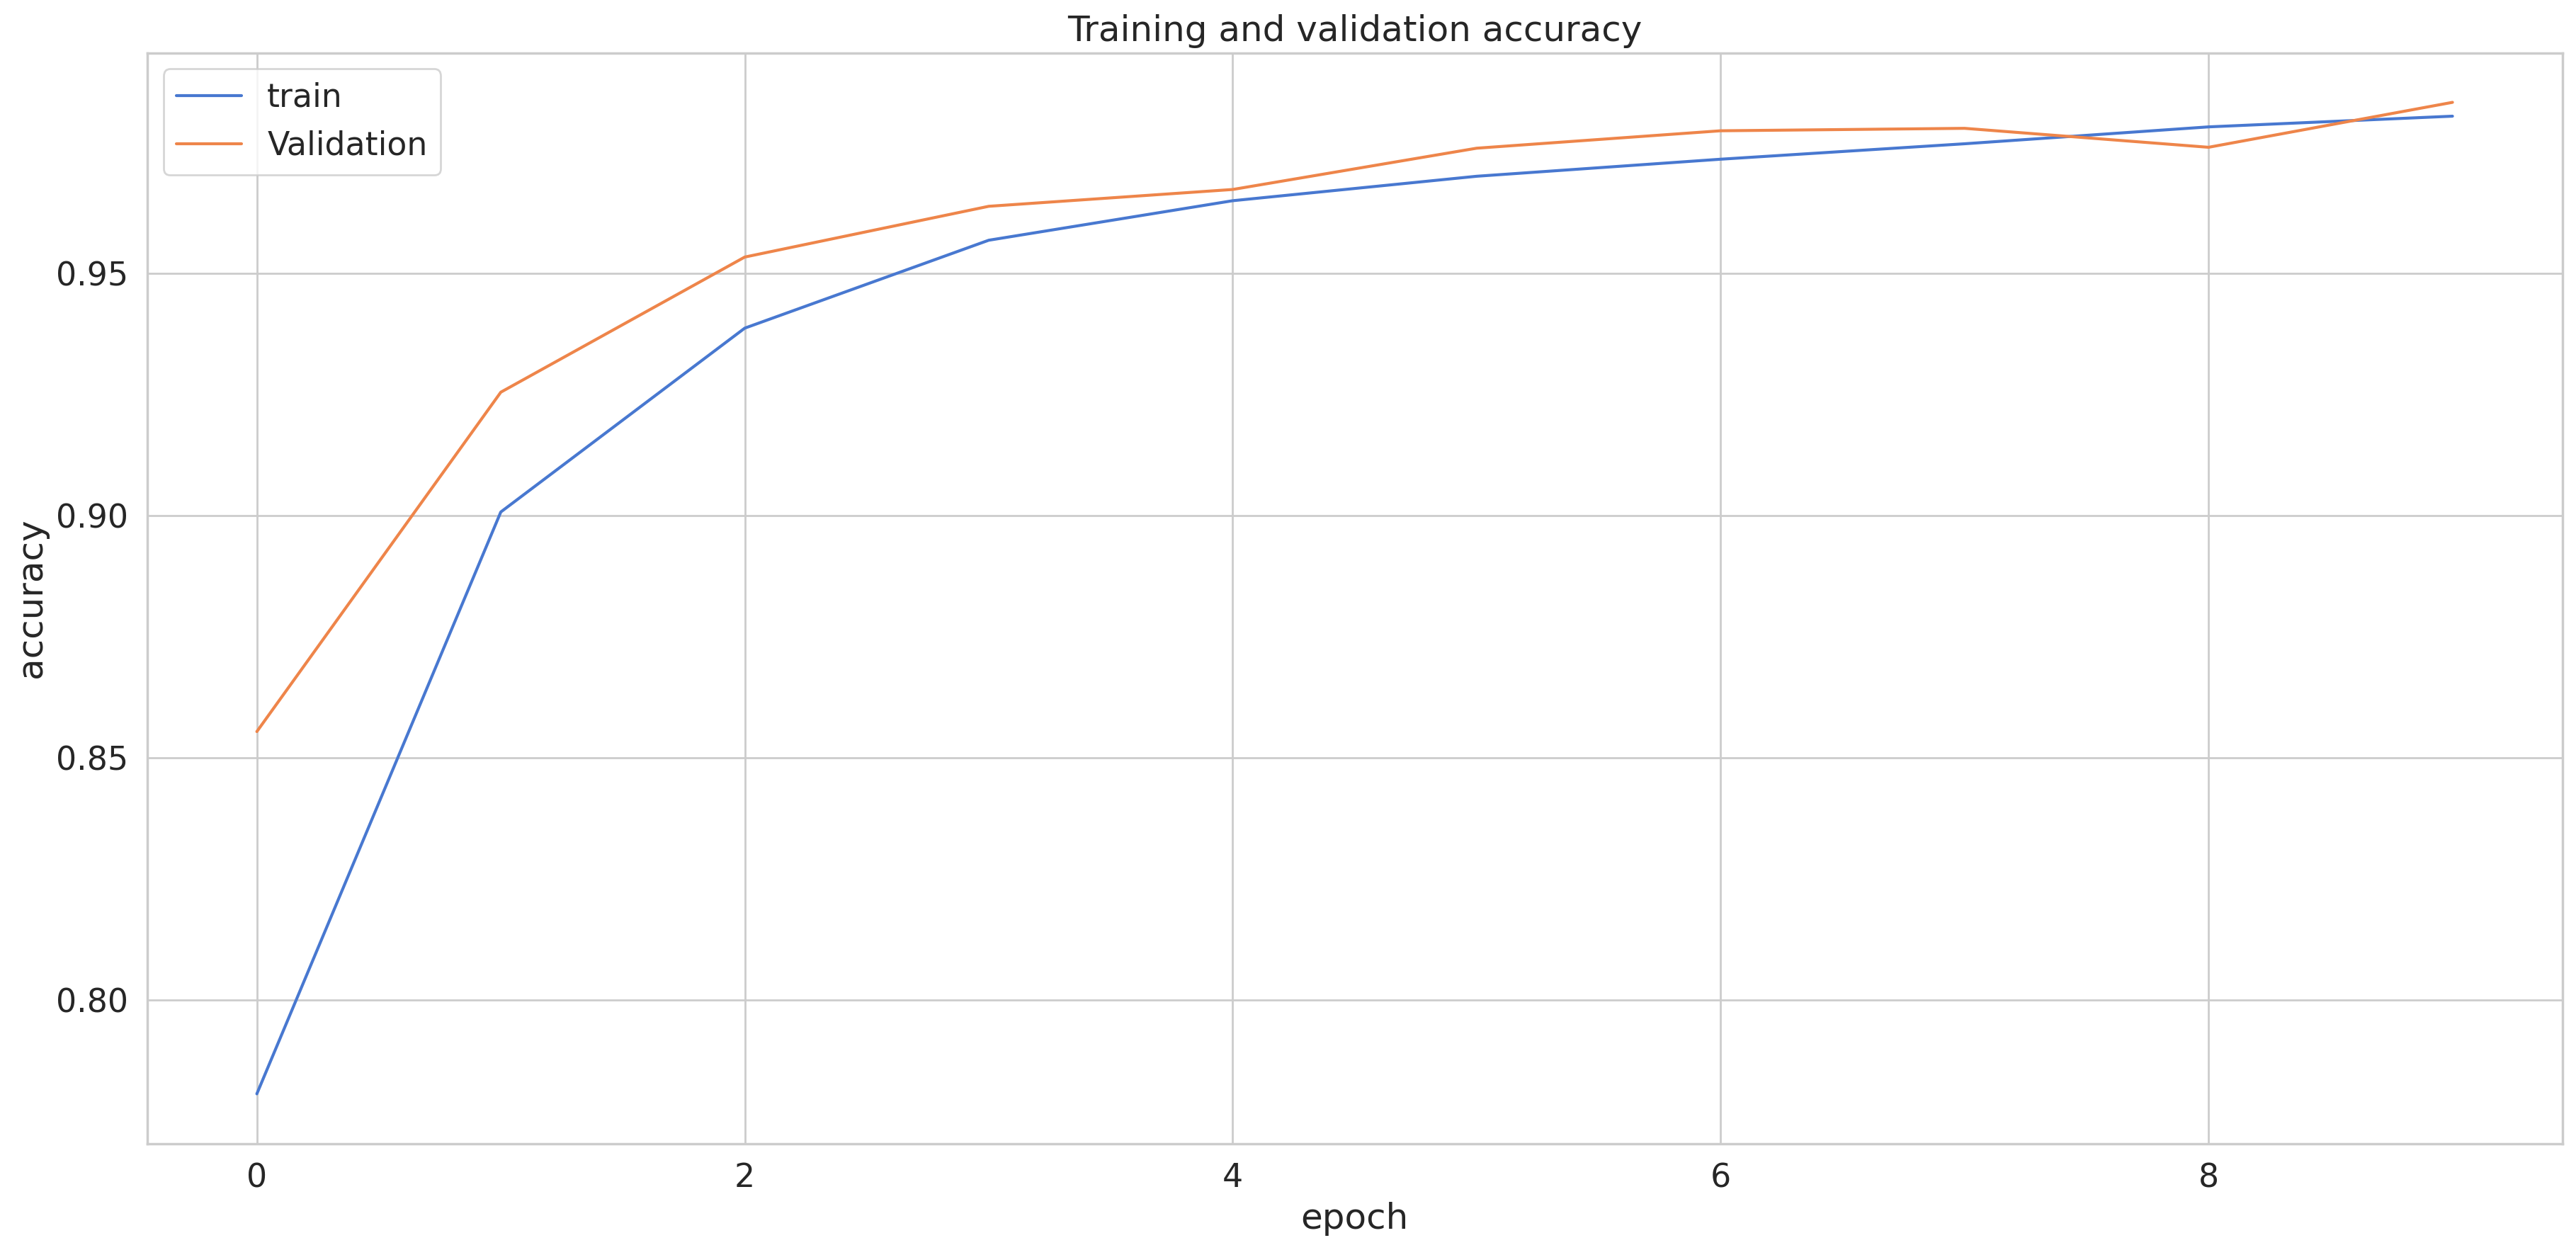

In [18]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

619/619 [==============================] - 101s 160ms/step
f1_score =  0.984322784632784
0.9842905490730919
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      8490
           1       0.99      0.99      0.99      6843
           2       0.95      0.96      0.95      2459
           3       0.95      0.95      0.95      2005

    accuracy                           0.98     19797
   macro avg       0.97      0.97      0.97     19797
weighted avg       0.98      0.98      0.98     19797



<Axes: >

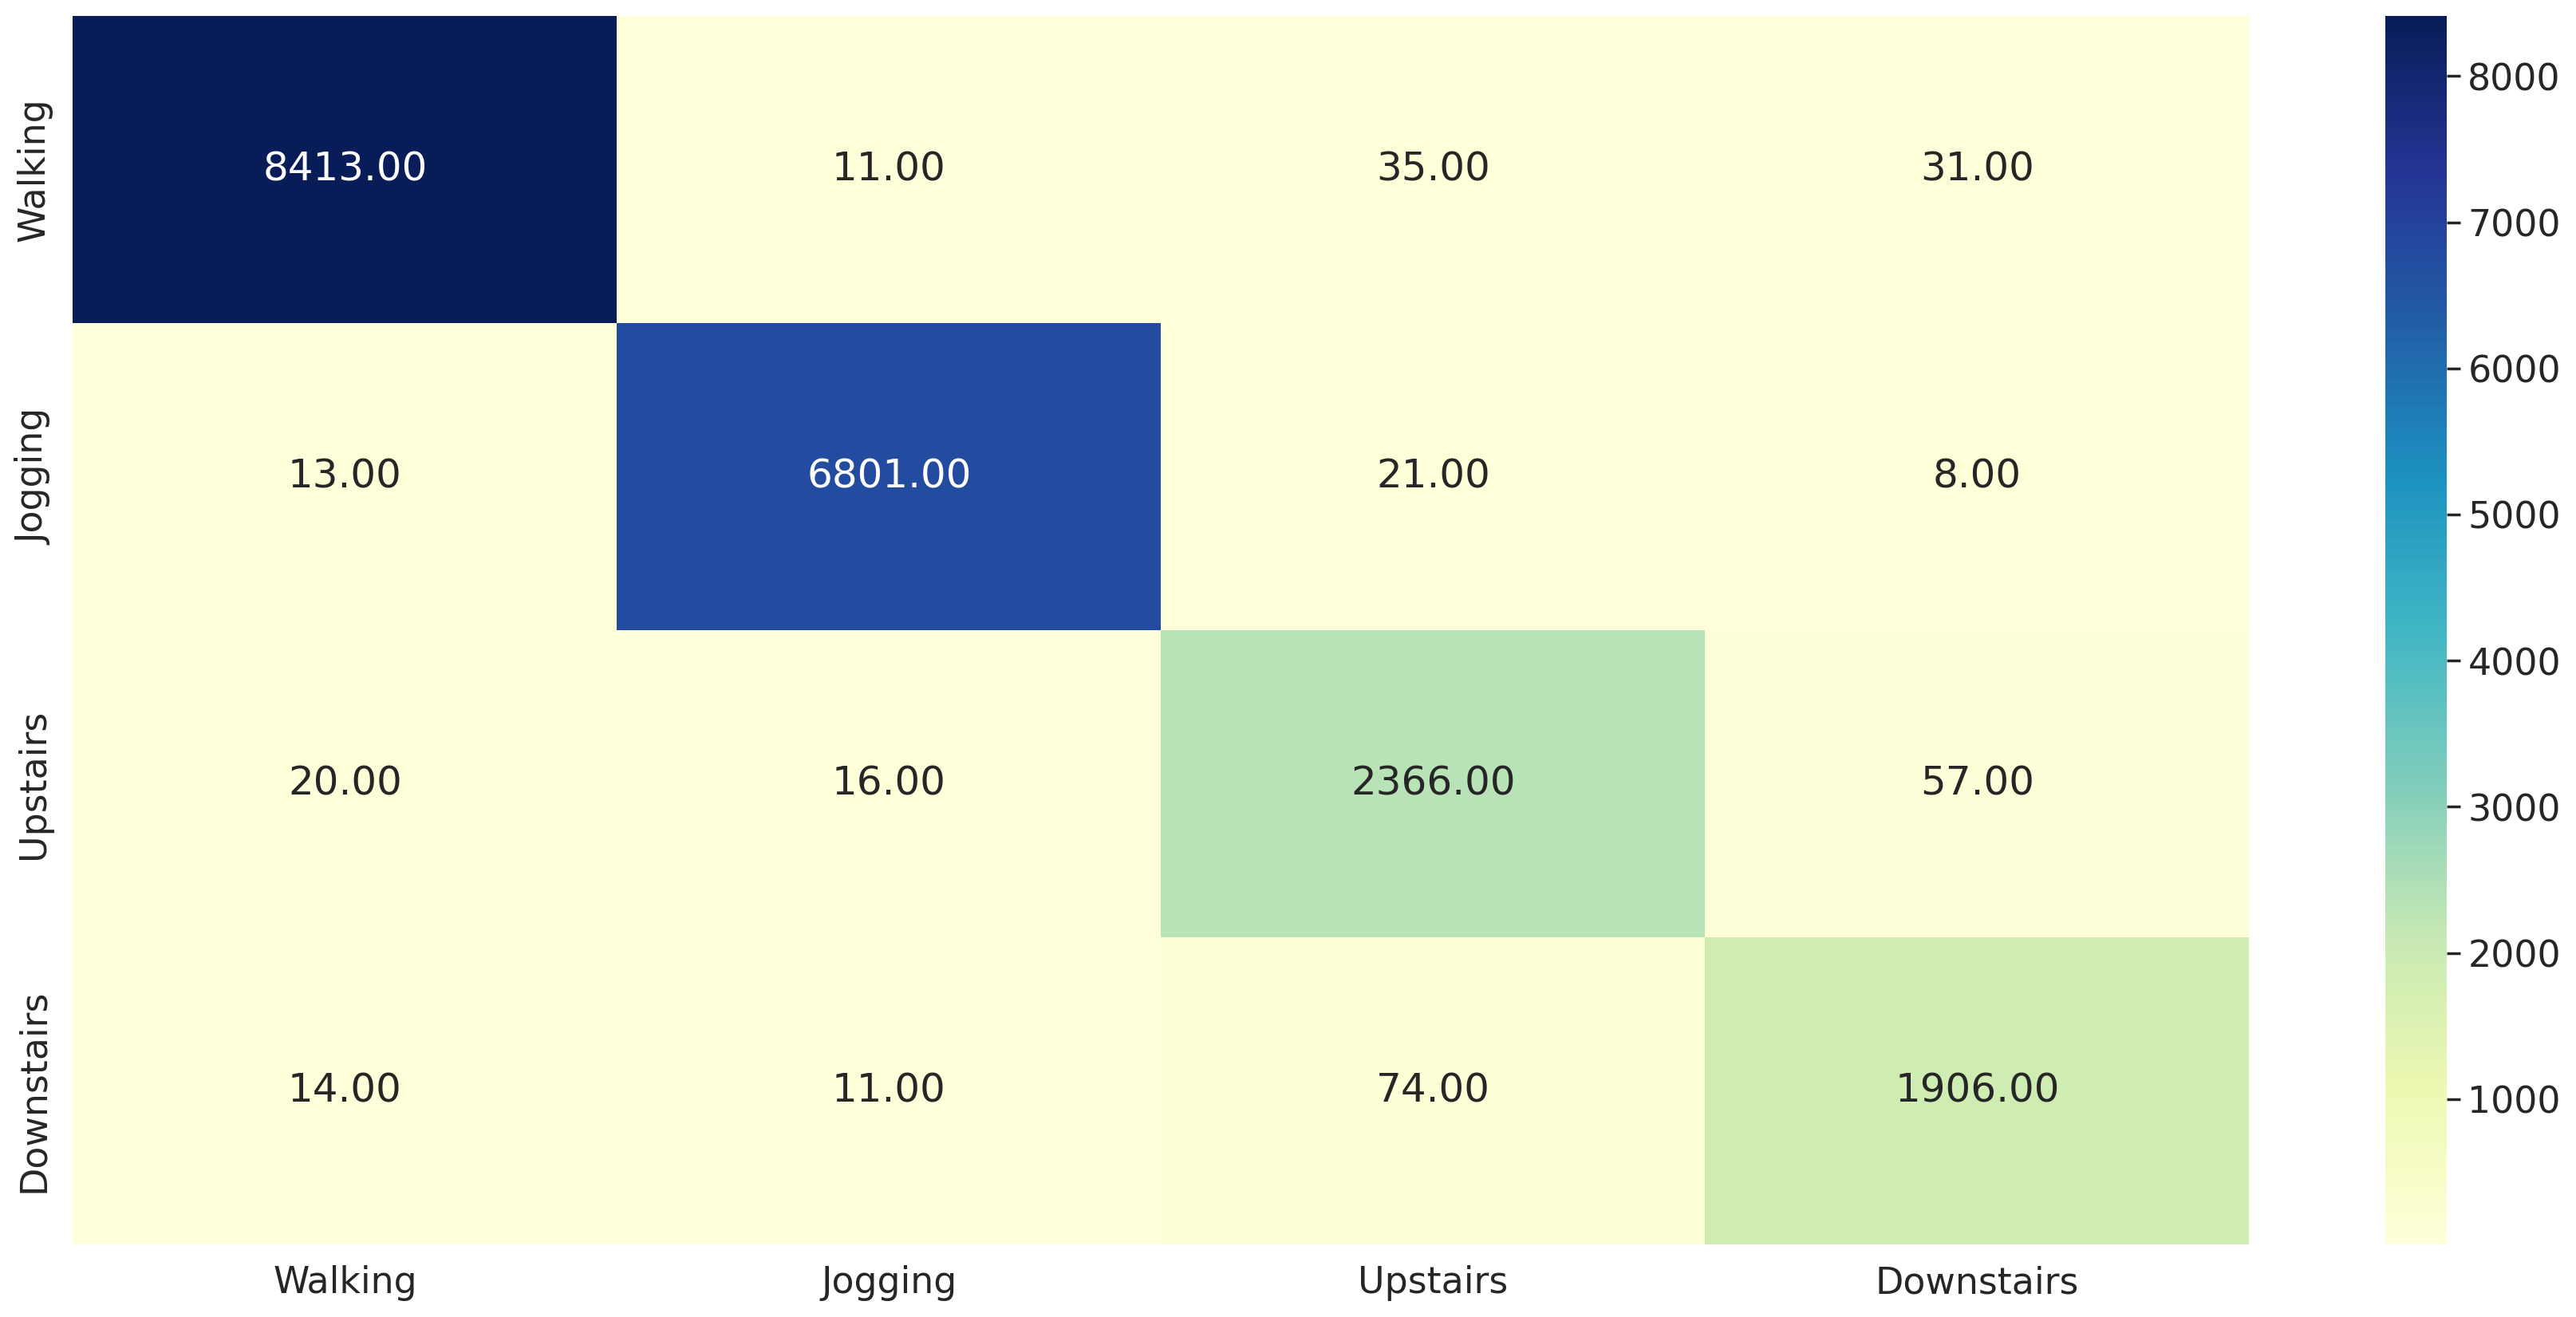

In [19]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

y_pred=model.predict(X_test)
y_pred = np.argmax(y_pred, axis=-1)
y_true = np.argmax(y_test_hot, axis=-1)

LABELS = ['Walking', 'Jogging', 'Upstairs', 'Downstairs']
cm=confusion_matrix(y_true,y_pred)

#print(cm)
print('f1_score = ', f1_score(y_test, y_pred, average='weighted'))
print(accuracy_score(y_true,y_pred))
print(classification_report(y_true,y_pred))
sns.heatmap(cm, cmap="YlGnBu", xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt = '.2f')